In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20200101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)



In [2]:
import numpy as np

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

# stock_df_raw[(stock_df_raw['Date'] == '2024-04-01') & (stock_df_raw['成交筆數'] < 100) & (stock_df_raw['收盤價'] < 100)].copy() 
# stock_df_raw[(stock_df_raw['Date'] > '2024-04-01') & (stock_df_raw['證券代號'] == '1110' )]['成交筆數'].iloc[0]

In [3]:
# 短波強勢股
stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2021-01-01' ) & (stock_df_raw['Date']<='2021-12-31' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date'])

pre_day = ""
rs20_rank_his = 100
# 檢查前波高低點差距
backday = 120

for day in stock_date_list:

        if(pre_day == ""):
               pre_day =  day
               continue

        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) &  (stock_df_raw['20RS_rank'] > 52) & (stock_df_raw['60RS_rank'] > 90) & (stock_df_raw['240RS_rank'] > 90) & (stock_df_raw['收盤價'] > stock_df_raw['10MA'] )].copy() 
        stock_id_list = stock_df_today['證券代號'].tolist()

        for stock_id in stock_id_list:

                # 查前一天的 20RS_rank
                stock_his_df = stock_df_raw[(stock_df_raw['Date'] == pre_day) & (stock_df_raw['證券代號'] == stock_id )]
                # 會部會遇到剛好原本很弱 停牌隔天爆噴的可能
                if not stock_his_df.empty:
                        rs20_rank_his = stock_his_df['20RS_rank'].iloc[0]
                else:
                        # 停牌的話只能查stock_df_raw往前找了
                        stock_his_df = stock_df_raw[(stock_df_raw['Date'] < pre_day) & (stock_df_raw['證券代號'] == stock_id )]
                        if not stock_his_df.empty:
                                rs20_rank_his = stock_his_df['20RS_rank'].iloc[-1]
                                
                # 過去
                stock_today = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )].iloc[0]
                today_close = stock_today['收盤價']
                stock_name = stock_today['證券名稱']
                stock_volume = stock_today['成交筆數']

                # stock_af_volume = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
                # stock_af_price  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                # stock_af_price3  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[3]
                
                if( (rs20_rank_his < 15) & (stock_volume > 1000)):

                        # 檢查前波高低點
                        df_his_min_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < day )]['收盤價'].rolling(backday).min().iloc[-1]
                        df_his_max_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < day )]['收盤價'].rolling(backday).max().iloc[-1]
                        
                        if (df_his_min_price != 0) and (df_his_max_price != 0):

                                if (today_close / df_his_min_price > 3) or (df_his_max_price / today_close > 1.25):
                                        continue
                                
                        result_df = pd.DataFrame({
                                '證券代號': [ stock_id],
                                '證券名稱': [stock_name],
                                '收盤價': [today_close],
                                'Date': [day]
                                })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)

        # 更新pre day
        pre_day =  day

collected_data


C:\Users\USER\AppData\Local\Temp\ipykernel_20428\1576165580.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collected_data = pd.concat([collected_data, result_df], ignore_index=True)


,證券代號,證券名稱,收盤價,Date
0,2028,威致,22.75,2021-01-25
1,6224,聚鼎,107.50,2021-02-05
2,3092,鴻碩,66.80,2021-02-17
3,6129,普誠,16.50,2021-02-17
4,6284,佳邦,77.10,2021-02-17
...,...,...,...,...
64,6138,茂達,253.50,2021-12-15
65,6265,方土昶,18.60,2021-12-21
66,8183,精星,70.90,2021-12-24
67,6182,合晶,84.70,2021-12-27


舊的程式效能比較差已捨棄

In [ ]:
# # 短波強勢股
# stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2023-04-01' ) & (stock_df_raw['Date']<='2023-05-31' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']

# collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', '明天收盤價','三天收盤價', 'Date'])

# for day in stock_date_list:

#         stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) &  (stock_df_raw['20RS_rank'] > 58) & (stock_df_raw['60RS_rank'] > 90) & (stock_df_raw['240RS_rank'] > 90) & (stock_df_raw['收盤價'] > stock_df_raw['10MA'] )].copy() 
#         stock_id_list = stock_df_today['證券代號'].tolist()

#         for stock_id in stock_id_list:

#                 # 有day 跟 stock_id
#                 stock_his = stock_df_raw[(stock_df_raw['Date'] < day) & (stock_df_raw['證券代號'] == stock_id )]
#                 # 過去
                
#                 rs20_rank_his = stock_his['20RS_rank'].iloc[-1]

#                 today_close = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
#                 stock_name = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['證券名稱'].iloc[0]
#                 stock_volume = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]


#                 stock_af_volume = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
#                 stock_af_price  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
#                 stock_af_price3  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[3]
                
#                 if( (rs20_rank_his < 15) & (stock_volume > 1000)):

#                         result_df = pd.DataFrame({
#                                 '證券代號': [ stock_id],
#                                 '證券名稱': [stock_name],
#                                 '收盤價': [today_close],
#                                 '明天收盤價': [0],
#                                 '三天收盤價': [0],
#                                 'Date': [day]
#                                 })
#                         # 删除全为NA的列，避免可能出现的警告
#                         result_df.dropna(axis=1, how='all', inplace=True)

#                         if not result_df.empty:
#                                 collected_data = pd.concat([collected_data, result_df], ignore_index=True)

# collected_data


In [5]:
# collected_data['Date'] = pd.to_datetime(collected_data['Date'])
# collected_data = collected_data[collected_data['Date'] < '2023-05-01']

In [3]:
# 存在本機
combined_df = pd.read_excel('c:/Users/USER/OneDrive/桌面/佛爾德/stock/combined_data_all2.xlsx')

# # ============================================
# test_data9 = collected_data
# stock_df_raw_tt = stock_df_raw[['Date','證券代號','5MA','10MA','20MA','60MA','20RS_rank','60RS_rank','240RS_rank']]
# merged_df = pd.merge(test_data9, stock_df_raw_tt, on=['Date', '證券代號'], how='inner')
# merged_df['5_boolean'] = merged_df['收盤價']> merged_df['5MA']
# merged_df['10_boolean'] = merged_df['收盤價']> merged_df['10MA']
# merged_df['20_boolean'] = merged_df['收盤價']> merged_df['20MA']
# merged_df['60_boolean'] = merged_df['收盤價']> merged_df['60MA']
# merged_df_2304 = merged_df.copy()


# # 縱向合併 merged_df_68 和 merged_df_46
# combined_df = pd.concat([combined_df, merged_df_2304], ignore_index=True)

# combined_df = combined_df.sort_values(by='Date')
# combined_df['Date'] = pd.to_datetime(combined_df['Date'])
# combined_df

In [9]:
# 如果還沒安裝 openpyxl，請先安裝：!pip install openpyxl
# 將 combined_df 存成 Excel 檔案
# 將 combined_df 存成 Excel 檔案到指定路徑

file_path = 'c:/Users/USER/OneDrive/桌面/佛爾德/stock/combined_data_all2.xlsx'
combined_df.to_excel(file_path, index=False)


符合條件者 
隔天收盤價買進
起算17天后收盤賣出

停損 : 出場看跌破60RS_RANK 88 隔天開盤直接賣出 


In [36]:
# collected_data_day[collected_data_day['earn_close'] > 0].sort_values(by='buy_date')

combined_df_first = combined_df.drop_duplicates(subset='證券代號', keep='first')
# combined_df_first = combined_df[combined_df['Date'] > '2023-05-01']


In [5]:
test_data12 = collected_data
stock_df_raw_tt = stock_df_raw[['Date','證券代號','5MA','10MA','20MA','60MA','20RS_rank','60RS_rank','240RS_rank']]
merged_df = pd.merge(test_data12, stock_df_raw_tt, on=['Date', '證券代號'], how='inner')
merged_df['5_boolean'] = merged_df['收盤價']> merged_df['5MA']
merged_df['10_boolean'] = merged_df['收盤價']> merged_df['10MA']
merged_df['20_boolean'] = merged_df['收盤價']> merged_df['20MA']
merged_df['60_boolean'] = merged_df['收盤價']> merged_df['60MA']
combined_df3 = merged_df.copy()
combined_df3

,證券代號,證券名稱,收盤價,Date,5MA,10MA,20MA,60MA,20RS_rank,60RS_rank,240RS_rank,5_boolean,10_boolean,20_boolean,60_boolean
0,2028,威致,22.75,2021-01-25,20.45,21.240,23.0925,18.8742,57.586207,93.505747,97.586207,True,True,False,True
1,6224,聚鼎,107.50,2021-02-05,100.26,101.920,104.1600,96.7300,87.263339,91.508893,90.189329,True,True,True,True
2,3092,鴻碩,66.80,2021-02-17,61.88,62.170,64.6750,58.9000,75.802752,90.309633,91.972477,True,True,True,True
3,6129,普誠,16.50,2021-02-17,15.38,15.865,16.3125,13.1557,58.600917,96.961009,98.050459,True,True,True,True
4,6284,佳邦,77.10,2021-02-17,72.96,73.620,75.3850,65.1717,68.807339,94.151376,97.534404,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,6138,茂達,253.50,2021-12-15,243.60,248.050,247.0750,197.6333,77.632328,95.162208,97.552647,True,True,True,True
65,6265,方土昶,18.60,2021-12-21,17.59,18.135,17.6175,13.3190,87.514253,98.004561,97.947548,True,True,True,True
66,8183,精星,70.90,2021-12-24,64.98,64.790,66.1150,53.2492,90.763968,96.294185,96.408210,True,True,True,True
67,6182,合晶,84.70,2021-12-27,82.52,82.510,83.6900,71.2183,54.410928,90.324417,93.340922,True,True,True,True


In [11]:
# import data 
combined_df = pd.read_excel('c:/Users/USER/OneDrive/桌面/佛爾德/stock/combined_data_all2.xlsx')
combined_df = combined_df[combined_df['收盤價'] < 400]
combined_df

,證券代號,證券名稱,收盤價,Date,5MA,10MA,20MA,60MA,20RS_rank,60RS_rank,240RS_rank,5_boolean,10_boolean,20_boolean,60_boolean
0,2028,威致,22.75,2021-01-25,20.45,21.240,23.0925,18.8742,57.586207,93.505747,97.586207,True,True,False,True
1,6224,聚鼎,107.50,2021-02-05,100.26,101.920,104.1600,96.7300,87.263339,91.508893,90.189329,True,True,True,True
2,3092,鴻碩,66.80,2021-02-17,61.88,62.170,64.6750,58.9000,75.802752,90.309633,91.972477,True,True,True,True
3,6129,普誠,16.50,2021-02-17,15.38,15.865,16.3125,13.1557,58.600917,96.961009,98.050459,True,True,True,True
4,6284,佳邦,77.10,2021-02-17,72.96,73.620,75.3850,65.1717,68.807339,94.151376,97.534404,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,8028,昇陽半導體,125.50,2024-09-13,118.20,120.850,126.5250,114.3733,58.221024,90.296496,97.897574,True,True,False,True
192,6535,順藥,256.50,2024-09-16,243.60,246.100,250.7750,231.4083,79.094828,90.355603,96.982759,True,True,True,True
193,4716,大立,24.95,2024-09-18,23.22,23.055,24.1275,21.8942,85.183190,93.157328,94.558190,True,True,True,True
194,6151,晉倫,40.80,2024-09-18,37.59,38.920,40.3975,34.2175,72.090517,95.797414,92.887931,True,True,True,True


In [5]:
# 調整購買比重

def weighted_price(price):
    if price < 20:
        return price * 20
    
    elif 20 <= price < 40:
        return price * 10  
    
    elif 40 <= price < 50:
        return price * 8  
    
    elif 50 <= price < 65:
        return price * 6    
      
    elif 65 <= price < 80:
        return price * 5    
    
    elif 80 <= price < 100:
        return price * 4

    elif 100 <= price < 130:
        return price * 3  
    
    elif 130 <= price < 200:
        return price * 2  
    
    elif 200 <= price :
        return price * 1  

備用 先不要動 改造新的 希望可以達成資金控管

In [45]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

loss_pen = 0.95
loss_type = 0
rs_rank_list = list(range(80, 81, 1)) # 77 
# rs_rank_list = list(range(21, 23, 1)) # 77 

total_earn_data = pd.DataFrame(columns=['hold_day','20rs_rank',
                                        'total_earn_close','total_earn_open','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min',
                                        'daily_need_money_max','daily_need_money_min', 'total_earn_moeny'])
for k in rs_rank_list:
    # k = 88
    j = 21

    collected_data_day = pd.DataFrame(columns=['證券代號','證券名稱','select_day', '收盤價',
                                               '明天收盤價','明天開盤價',
                                               'X天收盤價','X天開盤價',
                                               'earn_close','earn_open','earn_mix',
                                               'earn_nonsetloss_close','earn_nonsetloss_open',
                                               'buy_date', 'sell_date',
                                               'RS20','RS60','RS240',
                                               'loss_type',
                                               'GMFE','MAE','BMFE',
                                               'real_hold_day','not_sl_sell_date'])
    
    for i in range(len(combined_df)): # 這次跑的策略股票
        # 取出單一各股
        stock = combined_df.iloc[i]

        # 單一個股資本資訊
        stock_id = stock['證券代號']
        stock_name = stock['證券名稱']
        today_close = stock['收盤價']
        select_day = stock['Date']
        RS20 = stock['20RS_rank']
        RS60 = stock['60RS_rank']
        RS240 = stock['240RS_rank']

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        stock_af = stock_df_raw[(stock_df_raw['Date'] > select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 

        # 短波策略預計要抱 16 天 如果太新的股票先不列入
        if(len(stock_af) <  j+1):
              continue
        
        stock_close_price = stock_af['收盤價'].iloc[0] 
        stock_open_price = stock_af['開盤價'].iloc[0]
        buy_date = stock_af['Date'].iloc[0]

        stock_af_price_close = stock_af['收盤價'].iloc[j] # 賣出價收盤價
        stock_af_price_open = stock_af['開盤價'].iloc[j] # 賣出價開盤價

        sell_date = stock_af['Date'].iloc[j] # 賣出日
        not_sl_sell_date = stock_af['Date'].iloc[j]

        # 設定停損 RS RANK 停損
        loss_price = stock_close_price * loss_pen # 買進價的
        stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & 
                                   (stock_df_raw['Date'] > buy_date ) & 
                                   ((stock_df_raw['60RS_rank'] < k)  | (stock_df_raw['20RS_rank'] < 20) ) ].copy() # 避免假突破
        



        # 設定停損 價格停損
        # loss_price = stock_close_price * loss_pen # 買進價的
        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > buy_date ) & (stock_df_raw['收盤價'] < loss_price)].copy()


        # 設定停損 RS RANK 停損
        # loss_price = stock_close_price * loss_pen # 買進價的
        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] > buy_date ) & (stock_df_raw['收盤價'] < stock_df_raw['10MA'])].copy()

        # 測試如果完全不停損    
        earn_nonsetloss_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
        earn_nonsetloss_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
        loss_type = '1'

        # 計算 MAE BMFE GMFE
        stock_af_forMAE = stock_df_raw[(stock_df_raw['Date'] > buy_date.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] <= sell_date.strftime('%Y-%m-%d')) ].copy() 
        
        # 全域最大有利方向幅度
        GMFE = round( 100*((stock_af_forMAE['收盤價'].max()/stock_close_price)-1),2 )
        if (GMFE < 0):
            GMFE = 0
        # 全域最大不利方向幅度
        MAE = round( 100*((stock_af_forMAE['收盤價'].min()/stock_close_price)-1),2 )
        if (MAE > 0):
            MAE = 0

        MAE_day = stock_af_forMAE[stock_af_forMAE['收盤價'] == stock_af_forMAE['收盤價'].min()]['Date'].iloc[0]
        B_MAE_Date = stock_af_forMAE[stock_af_forMAE['Date'] <= MAE_day]

        # 全域最大有利方向幅度 (全域最大不利方向幅度前)
        BMFE = round( 100*((B_MAE_Date['收盤價'].max()/stock_close_price)-1),2 )

        if (BMFE < 0):
            BMFE = 0       

        # 多判斷是否停損不續抱著 
        if not stoploss_df.empty:
                stoploss_day_df = stoploss_df.iloc[0] # 符合條件當天停損

                if (stoploss_day_df['Date'] < sell_date):
                    # 需要隔天才能確認停損
                    stoploss_df_tommorrow = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > stoploss_day_df['Date'].strftime('%Y-%m-%d'))].copy()
                    tommorrow_df = stoploss_df_tommorrow.iloc[0]

                    earn_close = round( 100*((tommorrow_df['收盤價']/stock_close_price)-1),2 )  #隔天收盤停損
                    earn_open = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損
                    earn_mix = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損

                    sell_date = tommorrow_df['Date'] 
                    loss_type = '2'

                else:
                      earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
                      earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
                      earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣

        else :
            earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
            earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
            earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣



        real_hold_day = len(stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] >= buy_date) & (stock_df_raw['Date'] <= sell_date)])

        result_df = pd.DataFrame({
            '證券代號': [stock_id],
            '證券名稱': [stock_name],
            'select_day': [select_day],
            '收盤價': [today_close],
            '明天收盤價': [stock_close_price],
            '明天開盤價': [stock_open_price],
            'X天收盤價': [stock_af_price_close],
            'X天開盤價': [stock_af_price_open],
            'earn_close':[earn_close],
            'earn_open':[earn_open],
            'earn_mix':[earn_mix],
            'earn_nonsetloss_close':[earn_nonsetloss_close],
            'earn_nonsetloss_open':[earn_nonsetloss_open],
            'buy_date': [buy_date],
            'sell_date': [sell_date],
            'RS20': [RS20],
            'RS60': [RS60],
            'RS240': [RS240],
            'loss_type': [loss_type],
            'GMFE': [GMFE],
            'MAE': [MAE],
            'BMFE': [BMFE],
            'real_hold_day':[real_hold_day],
            'not_sl_sell_date':[not_sl_sell_date]
            })
        
        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
                collected_data_day = pd.concat([collected_data_day, result_df], ignore_index=True) 


    total_earn_close = collected_data_day['earn_close'].cumsum()    
    total_earn_open = collected_data_day['earn_open'].cumsum()    
    total_earn_mix= collected_data_day['earn_mix'].cumsum()    
    total_earn_nonsetloss_close = collected_data_day['earn_nonsetloss_close'].cumsum()    
    total_earn_nonsetloss_open = collected_data_day['earn_nonsetloss_open'].cumsum()    

    # 另外計算 ==============================
    collected_data_day['weighted_price'] = collected_data_day['明天收盤價'].apply(weighted_price)
    collected_data_day['weighted_earn_price'] = collected_data_day['weighted_price'] * collected_data_day['earn_mix'] / 100

    # tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
    
    earn_date_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','need_price'])

    for i in range(len(collected_data_day)):
        stock_info = collected_data_day.iloc[i]
        buy_date = stock_info['buy_date']
        sell_date = stock_info['sell_date']
        need_price = stock_info['weighted_price'] # 加權過後的明日收盤價

        # not_sl_sell_date = stock_info['not_sl_sell_date']

        stock_id = stock_info['證券代號']
        
        Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

        for day in Date_list:
            temp_df = pd.DataFrame({
                'hold_day': [day],
                'stock_id' : [stock_id],
                'need_price':[need_price]
            })

            # 删除全为NA的列，避免可能出现的警告
            temp_df.dropna(axis=1, how='all', inplace=True)
            if not temp_df.empty:
                earn_date_list = pd.concat([earn_date_list, temp_df], ignore_index=True)

        # 另外計算 ==============================

    earn_df = pd.DataFrame({
        'hold_day': [j],
        '20rs_rank': [k],
        'total_earn_close': [total_earn_close.iloc[-1]],
        'total_earn_open': [total_earn_open.iloc[-1]],
        'total_earn_mix': [total_earn_mix.iloc[-1]],
        'total_earn_nonsetloss_close': [total_earn_nonsetloss_close.iloc[-1]],
        'total_earn_nonsetloss_open': [total_earn_nonsetloss_open.iloc[-1]],
        'len': [len(collected_data_day[collected_data_day['loss_type'] == '2'])],
        'earn_close_min': [collected_data_day['earn_close'].min()],
        'earn_open_min': [collected_data_day['earn_open'].min()],
        'earn_mix_min': [collected_data_day['earn_mix'].min()],
        'earn_nonsetloss_open_min': [collected_data_day['earn_nonsetloss_open'].min()],
        'earn_nonsetloss_close_min': [collected_data_day['earn_nonsetloss_close'].min()],
        'daily_need_money_max':[earn_date_list.groupby('hold_day')['need_price'].sum().max()],
        'daily_need_money_min':[earn_date_list.groupby('hold_day')['need_price'].sum().min()],
        'total_earn_moeny':[collected_data_day['weighted_earn_price'].cumsum().iloc[-1]]
        })

        # 删除全为NA的列，避免可能出现的警告
    earn_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_earn_data = pd.concat([total_earn_data, earn_df], ignore_index=True) 

total_earn_data


,hold_day,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,daily_need_money_max,daily_need_money_min,total_earn_moeny
0,21,80,924.35,909.5,949.05,1078.58,911.97,148,-19.41,-15.22,-15.22,-35.93,-29.4,4637.3,162.4,3185.76323


In [168]:
# 目前持倉
position_stock = collected_data_day[(collected_data_day['buy_date'] < select_day) & (collected_data_day['sell_date'] > select_day) ]  # 同一天沒關係 剛好交割起來

if not position_stock.empty:

    position_stock['performance'] = np.nan 

    for j in range(len(position_stock)):
        temp_data = position_stock.iloc[j]
        day_data = stock_df_raw[(stock_df_raw['Date'] == select_day) & (stock_df_raw['證券代號'] == str(temp_data['證券代號']))]
        
                # If there is day data, calculate performance
        if not day_data.empty:
            # Calculate the performance
            performance = (day_data['收盤價'].values[0] - temp_data['明天收盤價']) / temp_data['明天收盤價']
            
            # Add the calculated performance to the 'performance' column in position_stock
            position_stock.iloc[j, position_stock.columns.get_loc('performance')] = performance
position_stock.sort_values(by='performance').head()

C:\Users\USER\AppData\Local\Temp\ipykernel_6040\703527109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_stock['performance'] = np.nan


,證券代號,證券名稱,收盤價,明天收盤價,明天開盤價,X天收盤價,X天開盤價,earn_close,earn_open,earn_mix,...,loss_type,GMFE,MAE,BMFE,real_hold_day,not_sl_sell_date,weighted_price,weighted_earn_price,tomorrow_diff,performance
10,1593,祺驊,121.0,127.00,126.0,116.50,118.50,-1.57,-4.72,-4.72,...,2,2.36,-9.06,2.36,8,2021-04-19,381.0,-17.98320,0.793651,-0.019685
11,1533,車王電,71.4,70.40,70.2,68.00,69.00,-0.85,-2.84,-2.84,...,2,1.28,-4.83,1.28,7,2021-04-21,352.0,-9.99680,0.284900,-0.018466
9,6237,驊訊,90.3,88.50,89.5,171.00,158.50,93.22,77.09,93.22,...,1,93.22,0.00,4.52,22,2021-04-09,354.0,329.99880,-1.117318,0.124294
5,3149,正達,28.8,28.35,27.8,37.85,39.15,33.51,40.83,33.51,...,1,39.86,-1.23,5.82,22,2021-03-23,283.5,95.00085,1.978417,0.398589


In [46]:
buy_date_list = collected_data_day[['select_day','證券代號','buy_date']]
buy_date_list.rename(columns={'select_day': 'Date'}, inplace=True)
merged_df = pd.merge(buy_date_list, combined_df, on=['Date', '證券代號'], how='inner')

C:\Users\USER\AppData\Local\Temp\ipykernel_1640\1308464654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_date_list.rename(columns={'select_day': 'Date'}, inplace=True)


In [47]:
merged_df

,Date,證券代號,buy_date,證券名稱,收盤價,5MA,10MA,20MA,60MA,20RS_rank,60RS_rank,240RS_rank,5_boolean,10_boolean,20_boolean,60_boolean
0,2021-01-25,2028,2021-01-26,威致,22.75,20.45,21.240,23.0925,18.8742,57.586207,93.505747,97.586207,True,True,False,True
1,2021-02-05,6224,2021-02-17,聚鼎,107.50,100.26,101.920,104.1600,96.7300,87.263339,91.508893,90.189329,True,True,True,True
2,2021-02-17,3092,2021-02-18,鴻碩,66.80,61.88,62.170,64.6750,58.9000,75.802752,90.309633,91.972477,True,True,True,True
3,2021-02-17,6129,2021-02-18,普誠,16.50,15.38,15.865,16.3125,13.1557,58.600917,96.961009,98.050459,True,True,True,True
4,2021-02-17,6284,2021-02-18,佳邦,77.10,72.96,73.620,75.3850,65.1717,68.807339,94.151376,97.534404,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2024-08-07,2363,2024-08-08,矽統,70.60,57.64,63.030,61.4000,59.2567,98.757428,96.812534,94.759589,True,True,True,True
178,2024-08-08,3450,2024-08-09,聯鈞,122.00,112.60,119.900,129.4750,110.7067,58.887088,94.705565,96.542410,True,True,False,True
179,2024-08-20,3686,2024-08-21,達能,28.60,26.56,26.845,27.9800,25.1425,62.978953,91.851052,95.358877,True,True,True,True
180,2024-08-27,4534,2024-08-28,慶騰,27.80,26.40,27.485,26.1475,23.1817,81.135135,94.270270,98.162162,True,True,True,True


In [49]:
collected_data_day2 = collected_data_day.copy()

In [62]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

loss_pen = 0.95
loss_type = 0
# rs_rank_list = list(range(80, 81, 1)) # 77 
# rs_rank_list = list(range(21, 23, 1)) # 77 

total_earn_data = pd.DataFrame(columns=['hold_day','20rs_rank',
                                        'total_earn_close','total_earn_open','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min',
                                        'daily_need_money_max','daily_need_money_min', 'total_earn_moeny'])

k = 88
j = 21

# 還沒碰到停損或是獲利了結提前被砍
cut_stock = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價',
                                        '明天收盤價','明天開盤價',
                                        'X天收盤價','X天開盤價',
                                        'earn_close','earn_open','earn_mix',
                                        'earn_nonsetloss_close','earn_nonsetloss_open',
                                        'buy_date', 'sell_date',
                                        'RS20','RS60','RS240',
                                        'loss_type',
                                        'GMFE','MAE','BMFE',
                                        'real_hold_day','not_sl_sell_date',
                                        'performance', 'cut_day'])

for i in range(len(merged_df)): # 這次跑的策略股票


    # 取出單一個股
    stock = merged_df.iloc[i]

    # 單一個股資本資訊
    stock_id = stock['證券代號']
    stock_name = stock['證券名稱']
    buy_date = stock['buy_date']  # 程式篩到的那天

    # step 1 檢視目前持倉
    # step 2 砍掉目前為止表現在差的
    # step 3 加入新的持股

    # 想法 既然期望值是好的 那篩到一隻也要資金全部打進去
    buy_count = len(merged_df[merged_df['Date'] == buy_date])

    # 目前持倉
    position_stock = collected_data_day2[(collected_data_day2['buy_date'] <= buy_date) & (collected_data_day2['sell_date'] > buy_date) ]  # 同一天沒關係 剛好交割起來
    
    # 如果目前沒持倉超過五檔就算了
    if (len(position_stock) + buy_count) > 5:

        need_cut_count = len(position_stock) + buy_count - 5

        position_stock['performance'] = np.nan 
        position_stock['cut_day'] = ''

        for j in range(len(position_stock)):
            temp_data = position_stock.iloc[j]
            day_data = stock_df_raw[(stock_df_raw['Date'] == buy_date) & (stock_df_raw['證券代號'] == str(temp_data['證券代號']))]
            
                    # If there is day data, calculate performance
            if not day_data.empty:
                # Calculate the performance
                performance = round(100*(day_data['收盤價'].values[0] - temp_data['明天收盤價']) / temp_data['明天收盤價'] , 2 )
                
                # Add the calculated performance to the 'performance' column in position_stock
                position_stock.iloc[j, position_stock.columns.get_loc('performance')] = performance

                # 下隻標的購買日等於這隻標的停損日
                position_stock.iloc[j, position_stock.columns.get_loc('cut_day')] = buy_date.strftime('%Y-%m-%d')


        # 把目前表現最爛的股票砍掉 換成新的來
        bad_per_list = position_stock[position_stock['performance'] < 0]
        if len(bad_per_list) > 0 :  # 才需要換股票

            bad_per_list = bad_per_list.sort_values(by='performance').head(need_cut_count) # 要被換掉的股票

        # 删除全为NA的列，避免可能出现的警告
        bad_per_list.dropna(axis=1, how='all', inplace=True)
        if not position_stock.empty:
                cut_stock = pd.concat([cut_stock, bad_per_list], ignore_index=True) 

cut_stock                

C:\Users\USER\AppData\Local\Temp\ipykernel_1640\3638331431.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_stock['performance'] = np.nan
C:\Users\USER\AppData\Local\Temp\ipykernel_1640\3638331431.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_stock['cut_day'] = ''
C:\Users\USER\AppData\Local\Temp\ipykernel_1640\3638331431.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

,證券代號,證券名稱,收盤價,明天收盤價,明天開盤價,X天收盤價,X天開盤價,earn_close,earn_open,earn_mix,...,GMFE,MAE,BMFE,real_hold_day,not_sl_sell_date,performance,cut_day,select_day,weighted_price,weighted_earn_price
0,3092,鴻碩,66.8,71.30,67.80,73.10,77.10,2.52,13.72,2.52,...,14.31,-2.81,4.91,22,2021-03-22,-2.52,2021-03-08,2021-02-17,356.5,8.98380
1,3685,元創精密,35.1,33.55,35.70,32.05,32.25,-0.89,-0.15,-0.15,...,1.49,-6.26,1.49,3,2021-04-08,-4.17,2021-03-09,2021-03-05,335.5,-0.50325
2,1593,祺驊,121.0,127.00,126.00,116.50,118.50,-1.57,-4.72,-4.72,...,2.36,-9.06,2.36,8,2021-04-19,-1.97,2021-03-19,2021-03-16,381.0,-17.98320
3,2617,台航,42.0,46.20,43.00,73.80,74.20,59.74,72.56,59.74,...,59.74,-14.18,0.00,22,2021-07-02,-7.79,2021-06-04,2021-06-01,369.6,220.79904
4,3060,銘異,27.6,30.35,29.00,27.45,26.80,-9.39,-9.06,-9.06,...,2.31,-12.69,2.31,16,2021-07-02,-2.80,2021-06-04,2021-06-01,303.5,-27.49710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2537,聯上發,17.5,17.90,17.75,22.70,22.90,-4.75,-6.70,-6.70,...,39.11,-6.98,0.00,6,2024-06-18,-3.91,2024-05-21,2024-05-16,358.0,-23.98600
71,2548,華固,163.0,166.50,162.00,186.50,189.00,-7.51,-5.71,-5.71,...,12.01,-7.51,1.50,5,2024-06-18,-3.00,2024-05-21,2024-05-16,333.0,-19.01430
72,1608,華榮,37.8,38.55,38.80,39.95,41.20,-3.63,-3.24,-3.24,...,6.23,-6.36,5.58,14,2024-06-17,-3.76,2024-05-29,2024-05-15,385.5,-12.49020
73,1608,華榮,37.8,38.55,38.80,39.95,41.20,-3.63,-3.24,-3.24,...,6.23,-6.36,5.58,14,2024-06-17,-3.76,2024-06-03,2024-05-15,385.5,-12.49020


In [73]:
cut_stock[['證券代號','證券名稱','earn_close','earn_close','earn_open','earn_mix','cut_day','sell_date','select_day','performance']]['performance']


0    -2.52
1    -4.17
2    -1.97
3    -7.79
4    -2.80
      ... 
70   -3.91
71   -3.00
72   -3.76
73   -3.76
74   -3.76
Name: performance, Length: 75, dtype: float64

In [50]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

loss_pen = 0.95
loss_type = 0
rs_rank_list = list(range(80, 81, 1)) # 77 
# rs_rank_list = list(range(21, 23, 1)) # 77 

total_earn_data = pd.DataFrame(columns=['hold_day','20rs_rank',
                                        'total_earn_close','total_earn_open','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min',
                                        'daily_need_money_max','daily_need_money_min', 'total_earn_moeny'])
for k in rs_rank_list:
    # k = 88
    j = 21

    collected_data_day3 = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價',
                                               '明天收盤價','明天開盤價',
                                               'X天收盤價','X天開盤價',
                                               'earn_close','earn_open','earn_mix',
                                               'earn_nonsetloss_close','earn_nonsetloss_open',
                                               'buy_date', 'sell_date',
                                               'RS20','RS60','RS240',
                                               'loss_type',
                                               'GMFE','MAE','BMFE',
                                               'real_hold_day','not_sl_sell_date'])
    # 還沒碰到停損或是獲利了結提前被砍
    cut_stock = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價',
                                            '明天收盤價','明天開盤價',
                                            'X天收盤價','X天開盤價',
                                            'earn_close','earn_open','earn_mix',
                                            'earn_nonsetloss_close','earn_nonsetloss_open',
                                            'buy_date', 'sell_date',
                                            'RS20','RS60','RS240',
                                            'loss_type',
                                            'GMFE','MAE','BMFE',
                                            'real_hold_day','not_sl_sell_date',
                                            'performance', 'cut_day'])
    
    for i in range(len(merged_df)): # 這次跑的策略股票


        # 取出單一個股
        stock = merged_df.iloc[i]

        # 單一個股資本資訊
        stock_id = stock['證券代號']
        stock_name = stock['證券名稱']
        buy_date = stock['buy_date']  # 程式篩到的那天
 
        # step 1 檢視目前持倉
        # step 2 砍掉目前為止表現在差的
        # step 3 加入新的持股

        # 想法 既然期望值是好的 那篩到一隻也要資金全部打進去
        buy_count = len(merged_df[merged_df['Date'] == buy_date])

        # 目前持倉
        position_stock = collected_data_day2[(collected_data_day2['buy_date'] <= buy_date) & (collected_data_day2['sell_date'] > buy_date) ]  # 同一天沒關係 剛好交割起來
        
        # 如果目前沒持倉超過五檔就算了
        if (len(position_stock) + buy_count) > 5:

            need_cut_count = len(position_stock) + buy_count - 5

            position_stock['performance'] = np.nan 
            position_stock['cut_day'] = ''

            for j in range(len(position_stock)):
                temp_data = position_stock.iloc[j]
                day_data = stock_df_raw[(stock_df_raw['Date'] == buy_date) & (stock_df_raw['證券代號'] == str(temp_data['證券代號']))]
                
                        # If there is day data, calculate performance
                if not day_data.empty:
                    # Calculate the performance
                    performance = (day_data['收盤價'].values[0] - temp_data['明天收盤價']) / temp_data['明天收盤價']
                    
                    # Add the calculated performance to the 'performance' column in position_stock
                    position_stock.iloc[j, position_stock.columns.get_loc('performance')] = performance

                    # 下隻標的購買日等於這隻標的停損日
                    position_stock.iloc[j, position_stock.columns.get_loc('cut_day')] = buy_date


            # 把目前表現最爛的股票砍掉 換成新的來
            bad_per_list = position_stock[position_stock['performance'] < 0]
            if len(bad_per_list) > 0 :  # 才需要換股票

                bad_per_list = bad_per_list.sort_values(by='performance').head(need_cut_count) # 要被換掉的股票

            # 删除全为NA的列，避免可能出现的警告
            bad_per_list.dropna(axis=1, how='all', inplace=True)
            if not position_stock.empty:
                    cut_stock = pd.concat([cut_stock, bad_per_list], ignore_index=True) 
                
                

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        stock_af = stock_df_raw[(stock_df_raw['Date'] > select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 

        # 短波策略預計要抱 16 天 如果太新的股票先不列入
        if(len(stock_af) <  j+1):
              continue
        
        stock_close_price = stock_af['收盤價'].iloc[0] 
        stock_open_price = stock_af['開盤價'].iloc[0]
        buy_date = stock_af['Date'].iloc[0]

        stock_af_price_close = stock_af['收盤價'].iloc[j] # 賣出價收盤價
        stock_af_price_open = stock_af['開盤價'].iloc[j] # 賣出價開盤價

        sell_date = stock_af['Date'].iloc[j] # 賣出日
        not_sl_sell_date = stock_af['Date'].iloc[j]

        # 設定停損 RS RANK 停損
        loss_price = stock_close_price * loss_pen # 買進價的
        stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & 
                                   (stock_df_raw['Date'] > buy_date ) & 
                                   ((stock_df_raw['60RS_rank'] < k)  | (stock_df_raw['20RS_rank'] < 20) ) ].copy() # 避免假突破
        

        # 測試如果完全不停損    
        earn_nonsetloss_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
        earn_nonsetloss_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
        
        loss_type = '1'

        # 計算 MAE BMFE GMFE
        stock_af_forMAE = stock_df_raw[(stock_df_raw['Date'] > buy_date.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] <= sell_date.strftime('%Y-%m-%d')) ].copy() 
        
        # 全域最大有利方向幅度
        GMFE = round( 100*((stock_af_forMAE['收盤價'].max()/stock_close_price)-1),2 )
        if (GMFE < 0):
            GMFE = 0
        # 全域最大不利方向幅度
        MAE = round( 100*((stock_af_forMAE['收盤價'].min()/stock_close_price)-1),2 )
        if (MAE > 0):
            MAE = 0

        MAE_day = stock_af_forMAE[stock_af_forMAE['收盤價'] == stock_af_forMAE['收盤價'].min()]['Date'].iloc[0]
        B_MAE_Date = stock_af_forMAE[stock_af_forMAE['Date'] <= MAE_day]

        # 全域最大有利方向幅度 (全域最大不利方向幅度前)
        BMFE = round( 100*((B_MAE_Date['收盤價'].max()/stock_close_price)-1),2 )

        if (BMFE < 0):
            BMFE = 0       

        # 多判斷是否停損不續抱著 
        if not stoploss_df.empty:
                stoploss_day_df = stoploss_df.iloc[0] # 符合條件當天停損

                if (stoploss_day_df['Date'] < sell_date):
                    # 需要隔天才能確認停損
                    stoploss_df_tommorrow = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > stoploss_day_df['Date'].strftime('%Y-%m-%d'))].copy()
                    tommorrow_df = stoploss_df_tommorrow.iloc[0]

                    earn_close = round( 100*((tommorrow_df['收盤價']/stock_close_price)-1),2 )  #隔天收盤停損
                    earn_open = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損
                    earn_mix = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損

                    sell_date = tommorrow_df['Date'] 
                    loss_type = '2'

                else:
                      earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
                      earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
                      earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣

        else :
            earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
            earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
            earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣



        real_hold_day = len(stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] >= buy_date) & (stock_df_raw['Date'] <= sell_date)])

        result_df = pd.DataFrame({
            '證券代號': [stock_id],
            '證券名稱': [stock_name],
            '收盤價': [today_close],
            '明天收盤價': [stock_close_price],
            '明天開盤價': [stock_open_price],
            'X天收盤價': [stock_af_price_close],
            'X天開盤價': [stock_af_price_open],
            'earn_close':[earn_close],
            'earn_open':[earn_open],
            'earn_mix':[earn_mix],
            'earn_nonsetloss_close':[earn_nonsetloss_close],
            'earn_nonsetloss_open':[earn_nonsetloss_open],
            'buy_date': [buy_date],
            'sell_date': [sell_date],
            'RS20': [RS20],
            'RS60': [RS60],
            'RS240': [RS240],
            'loss_type': [loss_type],
            'GMFE': [GMFE],
            'MAE': [MAE],
            'BMFE': [BMFE],
            'real_hold_day':[real_hold_day],
            'not_sl_sell_date':[not_sl_sell_date]
            })
        
        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
                collected_data_day3 = pd.concat([collected_data_day3, result_df], ignore_index=True) 


    total_earn_close = collected_data_day3['earn_close'].cumsum()    
    total_earn_open = collected_data_day3['earn_open'].cumsum()    
    total_earn_mix= collected_data_day3['earn_mix'].cumsum()    
    total_earn_nonsetloss_close = collected_data_day3['earn_nonsetloss_close'].cumsum()    
    total_earn_nonsetloss_open = collected_data_day3['earn_nonsetloss_open'].cumsum()    

    # 另外計算 ==============================
    collected_data_day3['weighted_price'] = collected_data_day3['明天收盤價'].apply(weighted_price)
    collected_data_day3['weighted_earn_price'] = collected_data_day3['weighted_price'] * collected_data_day3['earn_mix'] / 100

    # tt = collected_data_day3[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
    
    earn_date_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','need_price'])

    for i in range(len(collected_data_day3)):
        stock_info = collected_data_day3.iloc[i]
        buy_date = stock_info['buy_date']
        sell_date = stock_info['sell_date']
        need_price = stock_info['weighted_price'] # 加權過後的明日收盤價

        # not_sl_sell_date = stock_info['not_sl_sell_date']

        stock_id = stock_info['證券代號']
        
        Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

        for day in Date_list:
            temp_df = pd.DataFrame({
                'hold_day': [day],
                'stock_id' : [stock_id],
                'need_price':[need_price]
            })

            # 删除全为NA的列，避免可能出现的警告
            temp_df.dropna(axis=1, how='all', inplace=True)
            if not temp_df.empty:
                earn_date_list = pd.concat([earn_date_list, temp_df], ignore_index=True)

        # 另外計算 ==============================

    earn_df = pd.DataFrame({
        'hold_day': [j],
        '20rs_rank': [k],
        'total_earn_close': [total_earn_close.iloc[-1]],
        'total_earn_open': [total_earn_open.iloc[-1]],
        'total_earn_mix': [total_earn_mix.iloc[-1]],
        'total_earn_nonsetloss_close': [total_earn_nonsetloss_close.iloc[-1]],
        'total_earn_nonsetloss_open': [total_earn_nonsetloss_open.iloc[-1]],
        'len': [len(collected_data_day3[collected_data_day3['loss_type'] == '2'])],
        'earn_close_min': [collected_data_day3['earn_close'].min()],
        'earn_open_min': [collected_data_day3['earn_open'].min()],
        'earn_mix_min': [collected_data_day3['earn_mix'].min()],
        'earn_nonsetloss_open_min': [collected_data_day3['earn_nonsetloss_open'].min()],
        'earn_nonsetloss_close_min': [collected_data_day3['earn_nonsetloss_close'].min()],
        'daily_need_money_max':[earn_date_list.groupby('hold_day')['need_price'].sum().max()],
        'daily_need_money_min':[earn_date_list.groupby('hold_day')['need_price'].sum().min()],
        'total_earn_moeny':[collected_data_day3['weighted_earn_price'].cumsum().iloc[-1]]
        })

        # 删除全为NA的列，避免可能出现的警告
    earn_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_earn_data = pd.concat([total_earn_data, earn_df], ignore_index=True) 

total_earn_data


C:\Users\USER\AppData\Local\Temp\ipykernel_1640\1194521392.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_stock['performance'] = np.nan
C:\Users\USER\AppData\Local\Temp\ipykernel_1640\1194521392.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_stock['cut_day'] = ''
C:\Users\USER\AppData\Local\Temp\ipykernel_1640\1194521392.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

0      2.52
1      2.37
2     -2.35
3     57.39
4     48.33
      ...  
70   -27.48
71   -33.19
72   -36.43
73   -39.67
74   -42.91
Name: earn_mix, Length: 75, dtype: float64

In [92]:
total_earn_data

,hold_day,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,daily_need_money_max,daily_need_money_min,total_earn_moeny
0,21,80,924.35,909.50,949.05,1078.58,911.97,148,-19.41,-15.22,-15.22,-35.93,-29.4,4637.3,162.4,3185.76323
1,21,81,853.11,852.70,876.12,1078.58,911.97,149,-19.41,-15.22,-15.22,-35.93,-29.4,4637.3,162.4,2925.34972
2,21,82,857.47,872.15,895.57,1078.58,911.97,149,-19.41,-15.22,-15.22,-35.93,-29.4,4637.3,162.4,2982.18996
3,21,83,859.91,877.14,891.95,1078.58,911.97,150,-19.41,-15.22,-15.22,-35.93,-29.4,4353.8,162.4,2975.10594
4,21,84,846.27,887.76,902.57,1078.58,911.97,150,-19.41,-15.22,-15.22,-35.93,-29.4,4353.8,162.4,3012.79269
5,21,85,862.57,903.57,918.38,1078.58,911.97,150,-19.41,-15.22,-15.22,-35.93,-29.4,4353.8,162.4,3071.88146
6,21,86,728.99,759.77,786.76,1078.58,911.97,155,-19.41,-15.22,-15.22,-35.93,-29.4,4353.8,162.4,2735.10075
7,21,87,765.77,778.99,806.42,1078.58,911.97,157,-18.71,-14.03,-14.03,-35.93,-29.4,4353.8,162.4,2805.75147
8,21,88,752.91,759.16,786.56,1078.58,911.97,158,-18.71,-14.03,-14.03,-35.93,-29.4,4353.8,162.4,2744.04061
9,21,89,583.27,641.09,638.34,1078.58,911.97,160,-18.71,-14.03,-14.03,-35.93,-29.4,4353.8,162.4,2152.49339


In [9]:
total_earn_data

,hold_day,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,daily_need_money_max,daily_need_money_min,total_earn_moeny
0,21,80,873.51,781.67,826.25,1066.43,906.77,143,-14.9,-15.70,-35.93,-35.61,4470.5,162.4,2627.32060
1,21,81,790.57,718.48,746.93,1066.43,906.77,144,-14.9,-15.70,-35.93,-35.61,4470.5,162.4,2345.12778
2,21,82,762.93,726.78,743.71,1066.43,906.77,145,-14.9,-15.70,-35.93,-35.61,4470.5,162.4,2285.54108
3,21,83,753.74,720.40,738.91,1066.43,906.77,147,-14.9,-15.70,-35.93,-35.61,4470.5,162.4,2274.96951
4,21,84,744.38,740.85,755.78,1066.43,906.77,148,-14.9,-15.70,-35.93,-35.61,4470.5,162.4,2406.78626
5,21,85,767.32,777.92,782.66,1066.43,906.77,152,-14.9,-13.87,-35.93,-35.61,4470.5,162.4,2533.31620
6,21,86,668.40,626.87,643.79,1066.43,906.77,157,-14.9,-13.87,-35.93,-35.61,3825.6,162.4,2140.14380
7,21,87,681.77,623.75,627.97,1066.43,906.77,160,-14.9,-13.87,-35.93,-35.61,3825.6,162.4,2103.75945
8,21,88,697.58,618.57,623.33,1066.43,906.77,162,-14.9,-13.87,-35.93,-35.61,3825.6,162.4,2151.28729


In [159]:
total_earn_data

,hold_day,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min
0,18,88,634.00,593.86,575.02,908.99,820.89,155,-14.9,-13.87,-33.24,-32.50
1,19,88,680.29,590.03,620.38,965.39,809.37,157,-14.9,-13.87,-36.19,-28.44
2,20,88,634.16,655.81,576.71,934.48,906.55,159,-14.9,-13.87,-38.20,-33.40
3,21,88,701.10,620.33,625.09,1062.47,904.51,161,-14.9,-13.87,-35.93,-35.61
4,22,88,667.39,674.32,596.61,1028.32,986.25,164,-14.9,-13.87,-42.15,-42.02
5,23,88,628.66,598.78,563.43,941.02,920.83,168,-14.9,-13.87,-44.20,-43.54
6,24,88,675.65,621.72,609.00,931.76,906.21,170,-14.9,-13.87,-43.66,-47.12


In [90]:
collected_data_day[collected_data_day['earn_mix'] == -15.22].iloc[0:10,0:15]

collected_data_day[ (collected_data_day['buy_date'] >= '2021-09-03')  & (collected_data_day['buy_date'] <= '2021-09-08')].iloc[0:10,0:15]

,證券代號,證券名稱,收盤價,明天收盤價,明天開盤價,X天收盤價,X天開盤價,earn_close,earn_open,earn_mix,earn_nonsetloss_close,earn_nonsetloss_open,buy_date,sell_date,RS20
47,3556,禾瑞亞,97.3,95.3,99.1,74.0,74.1,-19.41,-15.22,-15.22,-22.35,-25.23,2021-09-03,2021-09-08,89.091947


隔天不管開盤收盤長怎樣好像都沒差 因為最後結果都沒有明顯虧錢 目前樣本數可能也不夠多 只能策略執行

而且跌最多的表現最好 代表會漲回來 代表說位置補得很漂亮

In [74]:
collected_data_day['tomorrow_diff'] = 100 * (collected_data_day['明天收盤價'] - collected_data_day['明天開盤價']) / collected_data_day['明天開盤價']
column = 'earn_nonsetloss_close'
print(collected_data_day[collected_data_day['tomorrow_diff'] < -9 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -9 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -8 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -8 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -7 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -7 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -6 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -6 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -8 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -5 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -4 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -4 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -3 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -3 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -2 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -2 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < -1 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] < -1 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] < 0 ][column].sum()  / len(collected_data_day[collected_data_day['tomorrow_diff'] < 0 ]))

# =========================================
print('=========================================')
print(collected_data_day[collected_data_day['tomorrow_diff'] == 0 ][column].sum()  / len(collected_data_day[collected_data_day['tomorrow_diff'] == 0 ]))
print('=========================================')
print(collected_data_day[collected_data_day['tomorrow_diff'] > 9 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 9 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 8 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 8 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 7 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 7 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 6 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 6 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 5 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 5 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 4 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 4 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 3 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 3 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 2 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 2 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 1 ][column].sum() / len(collected_data_day[collected_data_day['tomorrow_diff'] > 1 ]))
print(collected_data_day[collected_data_day['tomorrow_diff'] > 0 ][column].sum()  / len(collected_data_day[collected_data_day['tomorrow_diff'] > 0 ]))

24.615000000000002
31.615
25.730833333333326
13.438999999999998
7.5876
5.02025
4.688448275862067
3.843289473684211
4.257473684210525
4.7518518518518515
20.834000000000003
7.005
4.709999999999999
8.944444444444445
23.2325
13.478888888888893
10.119565217391301
7.867333333333334
7.7348780487804865
8.307037037037036
6.6842028985507245


In [75]:
collected_data_day

,證券代號,證券名稱,select_day,收盤價,明天收盤價,明天開盤價,X天收盤價,X天開盤價,earn_close,earn_open,...,RS240,loss_type,GMFE,MAE,BMFE,real_hold_day,not_sl_sell_date,weighted_price,weighted_earn_price,tomorrow_diff
0,2028,威致,2021-01-25,22.75,21.25,22.45,24.45,25.25,0.24,-4.00,...,97.586207,2,22.59,-7.76,0.24,3,2021-03-08,212.5,-8.50000,-5.345212
1,6224,聚鼎,2021-02-05,107.50,118.00,114.50,129.50,134.00,9.75,17.03,...,90.189329,1,16.95,0.00,13.14,22,2021-03-19,354.0,34.51500,3.056769
2,3092,鴻碩,2021-02-17,66.80,71.30,67.80,73.10,77.10,2.52,13.72,...,91.972477,1,14.31,-2.81,4.91,22,2021-03-22,356.5,8.98380,5.162242
3,6129,普誠,2021-02-17,16.50,17.60,16.50,45.00,42.60,155.68,158.18,...,98.050459,1,155.68,-0.57,0.00,22,2021-03-22,352.0,547.99360,6.666667
4,6284,佳邦,2021-02-17,77.10,76.50,76.90,80.30,78.90,2.75,-0.65,...,97.534404,2,10.85,-7.84,2.75,3,2021-03-22,382.5,-2.48625,-0.520156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2363,矽統,2024-08-07,70.60,67.50,70.00,62.50,61.60,-7.56,-6.52,...,94.759589,2,9.33,-9.33,9.33,20,2024-09-06,337.5,-22.00500,-3.571429
178,3450,聯鈞,2024-08-08,122.00,122.50,126.00,168.00,155.00,37.14,23.02,...,96.542410,1,45.71,0.00,3.67,22,2024-09-09,367.5,136.48950,-2.777778
179,3686,達能,2024-08-20,28.60,30.00,28.50,23.70,24.50,-9.67,-8.17,...,95.358877,2,0.33,-23.33,0.33,10,2024-09-20,300.0,-24.51000,5.263158
180,4534,慶騰,2024-08-27,27.80,28.60,27.75,24.55,24.50,-15.38,-9.09,...,98.162162,2,6.64,-18.01,6.64,10,2024-09-27,286.0,-25.99740,3.063063


In [76]:
# 如果每天要買得有多筆 用平均的話呢?
calculate_column = 'earn_mix'
calculate_column = 'earn_nonsetloss_close'

collected_data_day['buy_date'] = pd.to_datetime(collected_data_day['buy_date'])

earn_date_list = collected_data_day[['buy_date', calculate_column]]
earn_date_list = earn_date_list.groupby('buy_date')[calculate_column].size()

earn_date_list.columns = ['buy_date', calculate_column]
earn_date_list = earn_date_list.to_frame(name=calculate_column)
print(len(earn_date_list))
# earn_date_list[calculate_column].cumsum()
earn_date_list

145


,earn_nonsetloss_close
buy_date,
2021-01-26,1
2021-02-17,1
2021-02-18,3
2021-02-19,1
2021-02-23,2
...,...
2024-08-08,1
2024-08-09,1
2024-08-21,1


In [77]:
# 另外計算 ==============================
collected_data_day['weighted_price'] = collected_data_day['明天收盤價'].apply(weighted_price)
collected_data_day['weighted_earn_price'] = collected_data_day['weighted_price'] * collected_data_day['earn_mix'] / 100

# tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]

earn_date_list = pd.DataFrame(columns=['hold_day','stock_id','need_price','earn_money'])

for i in range(len(collected_data_day)):
    stock_info = collected_data_day.iloc[i]
    buy_date = stock_info['buy_date']
    sell_date = stock_info['sell_date']
    need_price = stock_info['weighted_price'] # 加權過後的明日收盤價
    earn_money = stock_info['weighted_earn_price'] # 加權過後的明日收盤價

    # not_sl_sell_date = stock_info['not_sl_sell_date']

    stock_id = stock_info['證券代號']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
            'need_price':[need_price],
            'earn_money':[earn_money]
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            earn_date_list = pd.concat([earn_date_list, temp_df], ignore_index=True)

earn_date_list  

earn_date_list2 = earn_date_list.groupby('hold_day').size()
earn_date_list2.columns = ['buy_date', 'size','earn_money']
earn_date_list2 = earn_date_list2.to_frame(name='size')

earn_date_list2

,size
hold_day,
2021-01-26,1
2021-01-27,1
2021-01-28,1
2021-02-17,1
2021-02-18,4
...,...
2024-09-23,1
2024-09-24,1
2024-09-25,1


In [98]:

collected_data_day['buy_date'] = pd.to_datetime(collected_data_day['buy_date'])
earn_list = collected_data_day.groupby('sell_date')['earn_mix'].sum()
earn_list.columns = ['sell_date', 'earn_mix']
earn_list = earn_list.to_frame(name='earn_mix')
earn_list.index



DatetimeIndex(['2021-01-28', '2021-02-22', '2021-02-26', '2021-03-05',
               '2021-03-10', '2021-03-19', '2021-03-22', '2021-03-23',
               '2021-03-26', '2021-03-29',
               ...
               '2024-06-24', '2024-06-28', '2024-07-09', '2024-07-30',
               '2024-08-27', '2024-09-03', '2024-09-04', '2024-09-09',
               '2024-09-10', '2024-09-27'],
              dtype='datetime64[ns]', name='sell_date', length=147, freq=None)

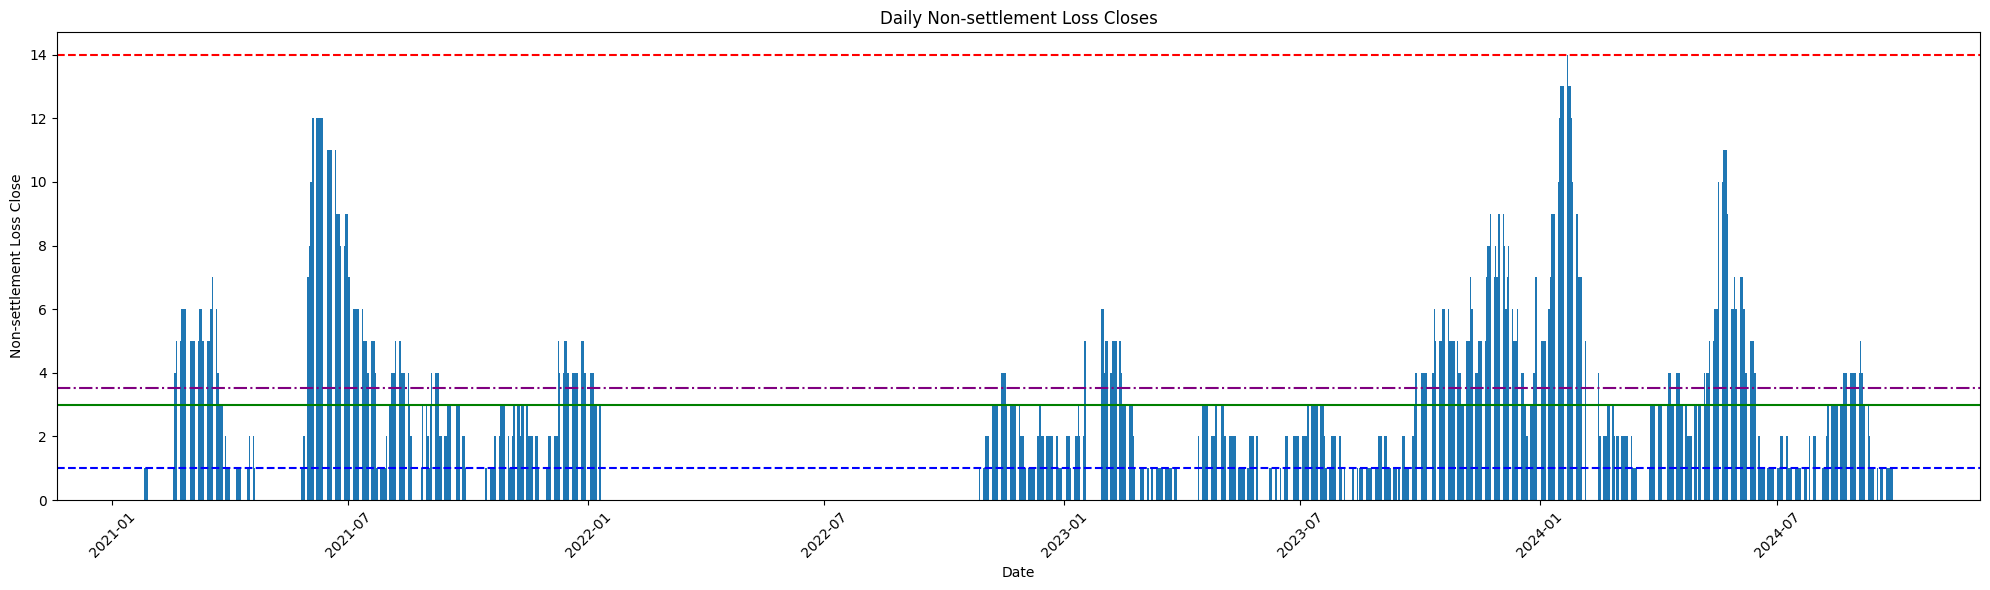

In [97]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 6))

# Plot a bar chart with dates on the x-axis and values on the y-axis
plt.bar(earn_date_list2.index, earn_date_list2['size'], width=1)

# Add horizontal lines for max, min, mean, and median
plt.axhline(earn_date_list2['size'].max(), color='red', linestyle='--', label=f'Max: {earn_date_list2['size'].max():.2f}')
plt.axhline(earn_date_list2['size'].min(), color='blue', linestyle='--', label=f'Min: {earn_date_list2['size'].min():.2f}')
plt.axhline(earn_date_list2['size'].median(), color='green', linestyle='-', label=f'Median: {earn_date_list2['size'].median():.2f}')
plt.axhline(earn_date_list2['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {earn_date_list2['size'].mean():.2f}')

# Add titles and labels
plt.title('Daily Non-settlement Loss Closes')
plt.xlabel('Date')
plt.ylabel('Non-settlement Loss Close')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


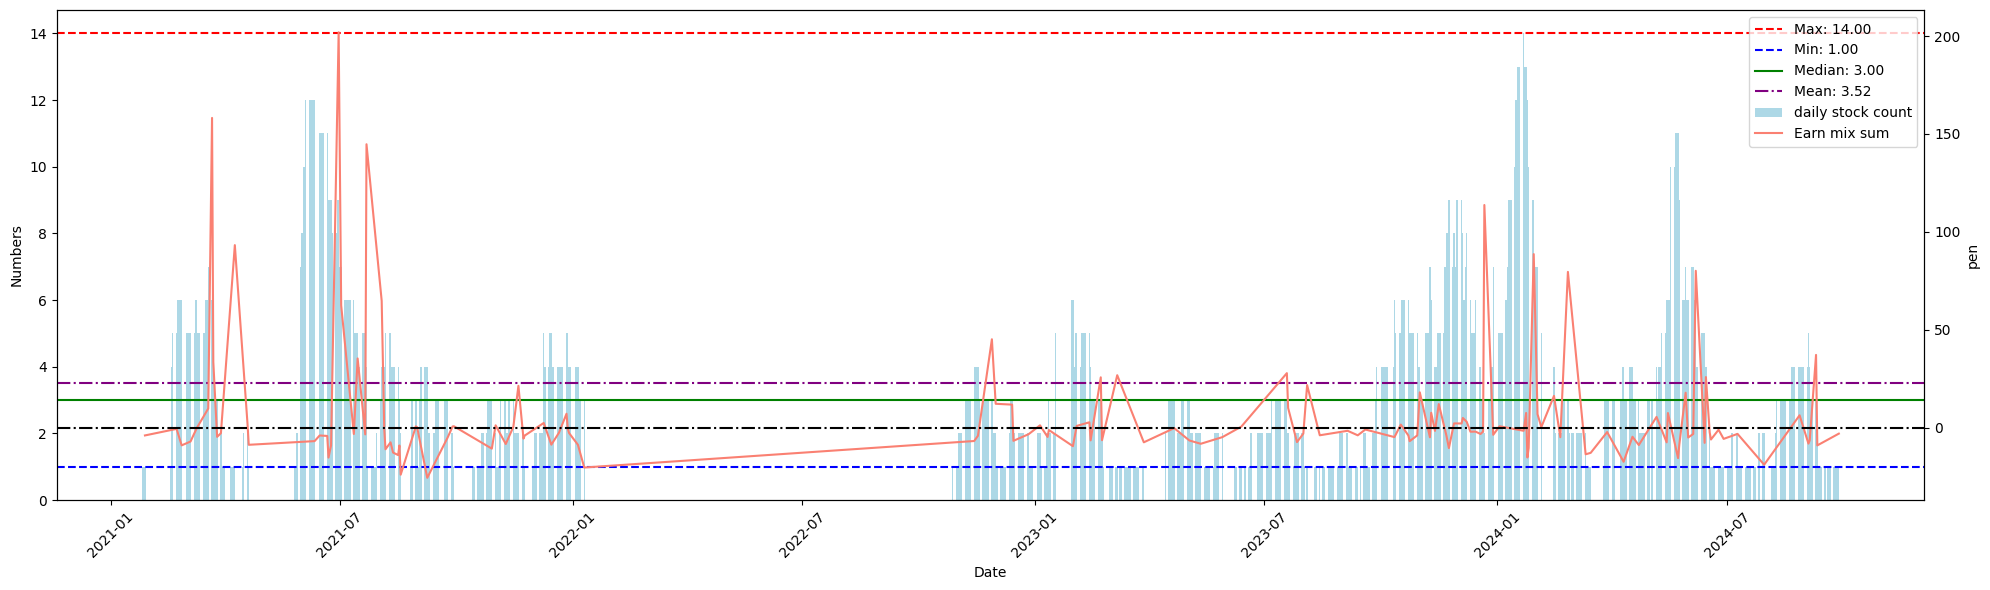

In [106]:
import matplotlib.pyplot as plt

# Set the figure size
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot the bar chart with dates on the x-axis and 'size' values on the primary y-axis
ax1.bar(earn_date_list2.index, earn_date_list2['size'], width=1, color='lightblue', label='daily stock count')

# Add horizontal lines for max, min, mean, and median on the primary y-axis
ax1.axhline(earn_date_list2['size'].max(), color='red', linestyle='--', label=f'Max: {earn_date_list2["size"].max():.2f}')
ax1.axhline(earn_date_list2['size'].min(), color='blue', linestyle='--', label=f'Min: {earn_date_list2["size"].min():.2f}')
ax1.axhline(earn_date_list2['size'].median(), color='green', linestyle='-', label=f'Median: {earn_date_list2["size"].median():.2f}')
ax1.axhline(earn_date_list2['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {earn_date_list2["size"].mean():.2f}')

# Set titles and labels for the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Numbers', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Rotate the x-axis labels for better readability
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the earn_mix line on the secondary y-axis
ax2.plot(earn_list.index, earn_list['earn_mix'], color='salmon', linestyle='-', label='Earn mix sum')
ax2.axhline(0, color='black', linestyle='-.')
# Set labels for the secondary y-axis
ax2.set_ylabel('percentage', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Add legends for both plots
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Tight layout to avoid overlap
fig.tight_layout()

# Show the plot
plt.show()


In [274]:
earn_date_list = earn_date_list.groupby('hold_day')['need_price'].sum()

earn_date_list.columns = ['buy_date', 'need_price']
earn_date_list = earn_date_list.to_frame(name='need_price')
earn_date_list.groupby('hold_day')['need_price'].sum().mean()

1048.775278810409

In [289]:
earn_date_list2 = earn_date_list.groupby('hold_day').size()

earn_date_list2.columns = ['buy_date', 'size','earn_money']
earn_date_list2 = earn_date_list2.to_frame(name='size')
earn_date_list2[earn_date_list2['size'] == 1].index

# earn_date_list[earn_date_list2[earn_date_list2['size'] == 1].index]

earn_date_list[earn_date_list['hold_day'].isin(earn_date_list2[earn_date_list2['size'] == 1].index.tolist())]

,hold_day,stock_id,need_price,earn_money
0,2021-01-26,2028,212.5,-8.5000
1,2021-01-27,2028,212.5,-8.5000
2,2021-01-28,2028,212.5,-8.5000
3,2021-02-17,6224,354.0,-1.4868
104,2021-04-15,8099,300.0,-12.0000
...,...,...,...,...
1701,2024-08-08,2363,337.5,4.9950
1738,2024-09-04,3450,367.5,136.4895
1739,2024-09-05,3450,367.5,136.4895
1740,2024-09-06,3450,367.5,136.4895


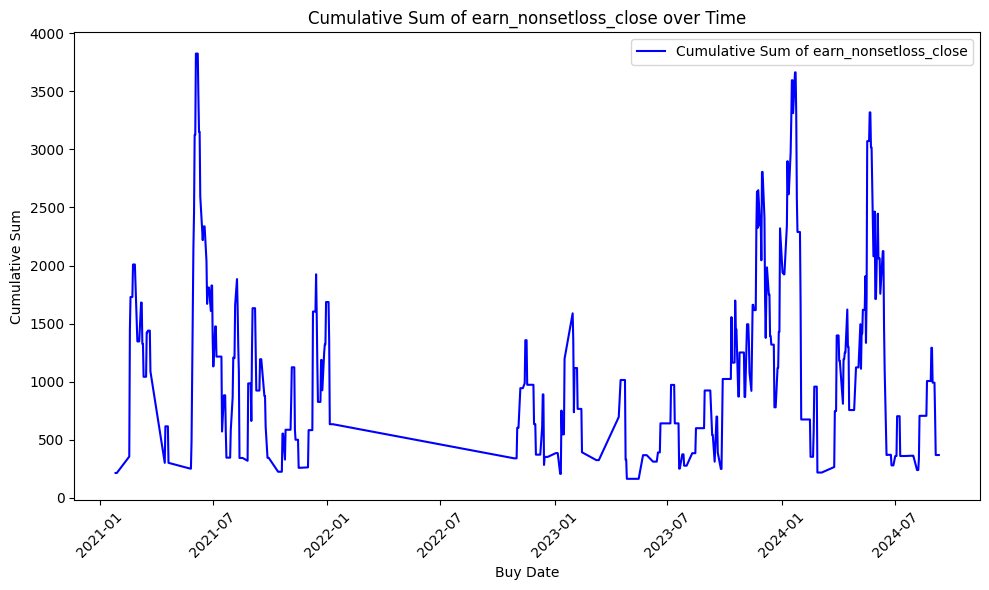

In [273]:
import matplotlib.pyplot as plt

earn_date_list = earn_date_list.groupby('hold_day')['need_price'].sum()

earn_date_list.columns = ['buy_date', 'need_price']
earn_date_list = earn_date_list.to_frame(name='need_price')


# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(earn_date_list.index, earn_date_list['need_price'], label='Cumulative Sum of earn_nonsetloss_close', color='b')

# 標題和軸標籤
plt.title('Cumulative Sum of earn_nonsetloss_close over Time')
plt.xlabel('Buy Date')
plt.ylabel('Cumulative Sum')

# 格式化 x 軸日期顯示
plt.xticks(rotation=45)

# 顯示圖例
plt.legend()

# 顯示圖表
plt.tight_layout()
plt.show()


In [259]:
# 調整購買比重

def weighted_price(price):
    if price < 20:
        return price * 20
    
    elif 20 <= price < 40:
        return price * 10  
    
    elif 40 <= price < 50:
        return price * 8  
    
    elif 50 <= price < 65:
        return price * 6    
      
    elif 65 <= price < 80:
        return price * 5    
    
    elif 80 <= price < 100:
        return price * 4

    elif 100 <= price < 130:
        return price * 3  
    
    elif 130 <= price < 200:
        return price * 2  
    
    elif 200 <= price :
        return price * 1  

collected_data_day['weighted_price'] = collected_data_day['明天收盤價'].apply(weighted_price)
collected_data_day['weighted_earn_price'] = collected_data_day['weighted_price'] * collected_data_day['earn_mix'] / 100

# tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']
earn_date_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','need_price'])

for i in range(len(collected_data_day)):
    stock_info = collected_data_day.iloc[i]
    buy_date = stock_info['buy_date']
    sell_date = stock_info['sell_date']
    need_price = stock_info['weighted_price'] # 加權過後的明日收盤價

    # not_sl_sell_date = stock_info['not_sl_sell_date']

    stock_id = stock_info['證券代號']
    daily_return = stock_info['daily_return']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
            'daily_return': [daily_return],
            'need_price':[need_price]
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            earn_date_list = pd.concat([earn_date_list, temp_df], ignore_index=True)

print(earn_date_list.groupby('hold_day')['need_price'].sum().max())
print(collected_data_day['weighted_earn_price'].cumsum().iloc[-1])




3825.6
2148.7847899999992


In [251]:
collected_data_day.sort_values(by='earn_mix', ascending=True).head(10)

,證券代號,證券名稱,收盤價,明天收盤價,明天開盤價,X天收盤價,X天開盤價,earn_close,earn_open,earn_mix,...,RS240,loss_type,GMFE,MAE,BMFE,real_hold_day,not_sl_sell_date,daily_return,weighted_price,weighted_earn_price
176,4534,慶騰,26.40,23.80,26.0,29.30,28.0,-0.63,-13.87,-13.87,...,98.217180,2,28.15,-9.66,0.00,3,2024-09-04,-4.623333,238.0,-33.01060
41,5285,界霖,118.00,114.00,116.0,100.00,102.0,-5.70,-13.51,-13.51,...,96.120936,2,14.04,-13.60,14.04,4,2021-09-14,-3.3775,228.0,-30.80280
38,4739,康普,121.00,121.50,118.0,112.00,112.0,-9.05,-12.76,-12.76,...,93.946316,2,3.29,-16.87,0.00,5,2021-09-07,-2.552,243.0,-31.00680
175,2486,一詮,133.00,120.50,126.0,98.50,95.2,-4.56,-11.62,-11.62,...,97.998918,2,0.00,-25.39,0.00,3,2024-08-27,-3.873333,241.0,-28.00420
49,4711,永純,20.35,22.35,21.7,21.35,21.2,-9.62,-10.74,-10.74,...,91.837900,2,6.49,-13.87,6.49,7,2021-11-15,-1.534286,223.5,-24.00390
86,2739,寒舍,59.50,65.40,60.7,62.30,62.0,-8.26,-10.55,-10.55,...,98.492462,2,13.61,-8.56,13.61,9,2023-05-17,-1.172222,261.6,-27.59880
46,2486,一詮,53.00,54.70,52.8,52.60,54.0,-11.70,-10.42,-10.42,...,98.458904,2,14.26,-11.70,0.00,5,2021-10-06,-2.084,328.2,-34.19844
39,6509,聚和,58.60,62.00,59.6,57.30,55.7,-7.58,-10.16,-10.16,...,97.772701,2,0.00,-18.39,0.00,5,2021-09-07,-2.032,372.0,-37.79520
65,6182,合晶,84.70,84.20,85.3,73.00,73.0,-4.99,-9.50,-9.50,...,93.340922,2,1.54,-13.30,1.54,9,2022-02-08,-1.055556,336.8,-31.99600
98,8210,勤誠,201.50,215.50,199.0,224.50,215.0,-9.74,-9.28,-9.28,...,99.168053,2,8.58,-9.74,8.58,20,2023-09-15,-0.464,215.5,-19.99840


In [158]:
# import matplotlib.pyplot as plt

# # 累計和數據
# cumulative_sum = collected_data_day['earn_nonsetloss_close'].cumsum()

# # 繪圖
# plt.figure(figsize=(10, 6))
# plt.plot(collected_data_day['buy_date'], cumulative_sum, label='Cumulative Sum of earn_nonsetloss_close', color='b')

# # 標題和軸標籤
# plt.title('Cumulative Sum of earn_nonsetloss_close over Time')
# plt.xlabel('Buy Date')
# plt.ylabel('Cumulative Sum')

# # 格式化 x 軸日期顯示
# plt.xticks(rotation=45)

# # 顯示圖例
# plt.legend()

# # 顯示圖表
# plt.tight_layout()
# plt.show()


解釋可以看這個
https://www.aicoin.com/zh-Hant/article/112540

Cumulative returns 是用 cumulative_returns = (1 + earn_date_list[calculate_column]).cumprod() - 1 去算的


In [66]:
calculate_column = 'earn_nonsetloss_close'
collected_data_day['buy_date'] = pd.to_datetime(collected_data_day['buy_date'])

earn_date_list = collected_data_day[['buy_date', calculate_column]]
earn_date_list = earn_date_list.groupby('buy_date')[calculate_column].sum()

earn_date_list.columns = ['buy_date', calculate_column]
earn_date_list = earn_date_list.to_frame(name=calculate_column)
earn_date_list[calculate_column] = earn_date_list[calculate_column] / 100
earn_date_list[calculate_column].cumsum()

collected_data_day[calculate_column] / collected_data_day['real_hold_day']



0      6.666667
1      0.877857
2      0.958333
3        6.0225
4           1.7
         ...   
185   -0.397895
186      1.3265
187        -2.5
188     -2.4925
189   -0.440667
Length: 190, dtype: object

In [91]:
calculate_column = 'earn_nonsetloss_close'
collected_data_day['buy_date'] = pd.to_datetime(collected_data_day['buy_date'])
# 為了pyfolio 要改成每日收益率
collected_data_day['daily_return'] = collected_data_day[calculate_column] / collected_data_day['real_hold_day']

earn_date_list = collected_data_day[['buy_date', 'daily_return']]
earn_date_list = earn_date_list.groupby('buy_date')['daily_return'].sum()

earn_date_list.columns = ['buy_date', 'daily_return']
earn_date_list = earn_date_list.to_frame(name='daily_return')

# earn_date_list.set_index(['buy_date'], inplace=True)


import pyfolio as pf
earn_date_list['daily_return'] = earn_date_list['daily_return'] / 100
earn_date_list['daily_return'] = pd.to_numeric(earn_date_list['daily_return'], errors='coerce')
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')
# pf.create_returns_tear_sheet( earn_date_list['daily_return'] )

sortino_ratio = pf.timeseries.sortino_ratio(earn_date_list['daily_return'])
max_drawdown = pf.timeseries.max_drawdown(earn_date_list['daily_return'])
annual_return = pf.timeseries.annual_return(earn_date_list['daily_return'])

sortino_ratio * annual_return / abs(max_drawdown)


C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3592521947.py:22: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  sortino_ratio = pf.timeseries.sortino_ratio(earn_date_list['daily_return'])
C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3592521947.py:23: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  max_drawdown = pf.timeseries.max_drawdown(earn_date_list['daily_return'])
C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3592521947.py:24: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  annual_return = pf.timeseries.annual_return(earn_date_list['daily_return'])


142.73969990897547

In [213]:


stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

calculate_column = 'earn_nonsetloss_close'
calculate_column = 'earn_mix'

collected_data_day['buy_date'] = pd.to_datetime(collected_data_day['buy_date'])
# 為了pyfolio 要改成每日收益率
collected_data_day['daily_return'] = collected_data_day[calculate_column] / collected_data_day['real_hold_day']

earn_date_list = pd.DataFrame(columns=['hold_day','stock_id', 'daily_return','price'])

for i in range(len(collected_data_day)):
    stock_info = collected_data_day.iloc[i]
    buy_date = stock_info['buy_date']

    sell_date = stock_info['sell_date']
    price = stock_info['收盤價']

    # not_sl_sell_date = stock_info['not_sl_sell_date']

    stock_id = stock_info['證券代號']
    daily_return = stock_info['daily_return']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        result_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
            'daily_return': [daily_return],
            'price':[price]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
            earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True)


earn_date_list_group = earn_date_list.groupby('hold_day')['daily_return'].sum()

earn_date_list_group.columns = ['hold_day', 'daily_return']
earn_date_list_group = earn_date_list_group.to_frame(name='daily_return')

# earn_date_list.set_index(['buy_date'], inplace=True)

import pyfolio as pf
earn_date_list_group['daily_return'] = pd.to_numeric(earn_date_list_group['daily_return'], errors='coerce')
earn_date_list_group['daily_return'] = earn_date_list_group['daily_return'] / 100

#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')

# pf.create_returns_tear_sheet( earn_date_list_group['daily_return'] )

# sortino_ratio = pf.timeseries.sortino_ratio(earn_date_list_group['daily_return'])
# max_drawdown = pf.timeseries.max_drawdown(earn_date_list_group['daily_return'])
# annual_return = pf.timeseries.annual_return(earn_date_list_group['daily_return'])

# sortino_ratio * annual_return / abs(max_drawdown)


In [233]:
tt = collected_data_day[['證券名稱','證券代號','收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]

earn_date_list_group['daily_return'].cumsum()

earn_date_list[earn_date_list['hold_day'] > '2021-06-01']

tt['buy_date'] = pd.to_datetime(tt['buy_date'])
tt[tt['buy_date'] > '2021-05-20'].head(50)


def weighted_price(price):
    if price < 50:
        return price * 8
    elif 50 <= price <= 100:
        return price * 4
    elif 100 <= price <= 200:
        return price * 2  # 假設超過 50 的價格權重為 3，可以根據需求調整
    elif 200 <= price :
        return price * 1  # 假設超過 50 的價格權重為 3，可以根據需求調整    

earn_date_list['weighted_price'] = earn_date_list['price'].apply(weighted_price)


k_group_columns = earn_date_list.groupby('hold_day')['weighted_price'].sum()
# k_group_columns.max()

k_group_columns.columns = ['hold_day', 'total_price']
k_group_columns = k_group_columns.to_frame(name='total_price')
# k_group_columns[k_group_columns['total_price'] == 1797.75]

# tt[tt['收盤價'] > 320]

tt['buy_date'] = pd.to_datetime(tt['buy_date'])
earn_date_list[earn_date_list['hold_day'] == '2024-01-17']


k_group_columns.max()


C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3619059570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['buy_date'] = pd.to_datetime(tt['buy_date'])
C:\Users\USER\AppData\Local\Temp\ipykernel_25660\3619059570.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['buy_date'] = pd.to_datetime(tt['buy_date'])


total_price    3057.4
dtype: float64

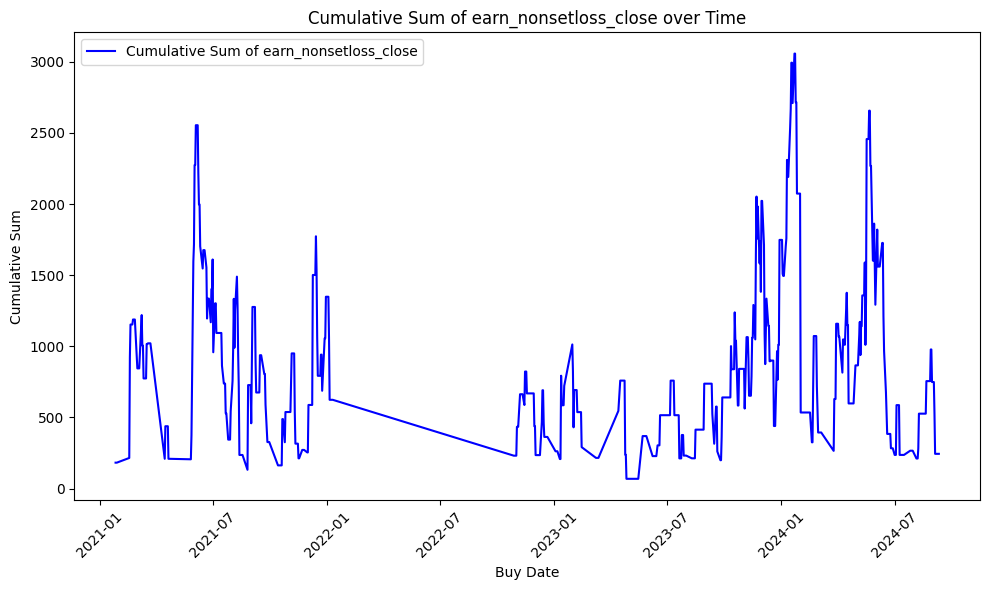

In [232]:
import matplotlib.pyplot as plt

# 累計和數據
cumulative_sum = collected_data_day['earn_nonsetloss_close'].cumsum()

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(k_group_columns.index, k_group_columns['total_price'], label='Cumulative Sum of earn_nonsetloss_close', color='b')

# 標題和軸標籤
plt.title('Cumulative Sum of earn_nonsetloss_close over Time')
plt.xlabel('Buy Date')
plt.ylabel('Cumulative Sum')

# 格式化 x 軸日期顯示
plt.xticks(rotation=45)

# 顯示圖例
plt.legend()

# 顯示圖表
plt.tight_layout()
plt.show()

In [143]:

earn_date_list['stock_id'] = earn_date_list['stock_id'].astype(str)
earn_date_list[earn_date_list['hold_day'] == '2021-02-18']



,hold_day,stock_id,daily_return
4,2021-02-18,6224,0.877857
17,2021-02-18,3092,0.958333
29,2021-02-18,6129,6.022500
49,2021-02-18,6284,1.700000


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-01-02
End date,2020-10-15
Total months,9
,Backtest
Annual return,182172.076%
Cumulative returns,28639.517%
Annual volatility,368.592%
Sharpe ratio,3.47
Calmar ratio,2099.96
Stability,0.69
Max drawdown,-86.75%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,86.75,2020-03-02,2020-04-21,2020-07-07,92
1,65.57,2020-08-17,2020-08-28,2020-09-11,20
2,63.45,2020-01-15,2020-02-03,2020-02-10,19
3,63.36,2020-07-08,2020-07-27,2020-08-17,29
4,58.06,2020-09-21,2020-10-15,NaT,NaN


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


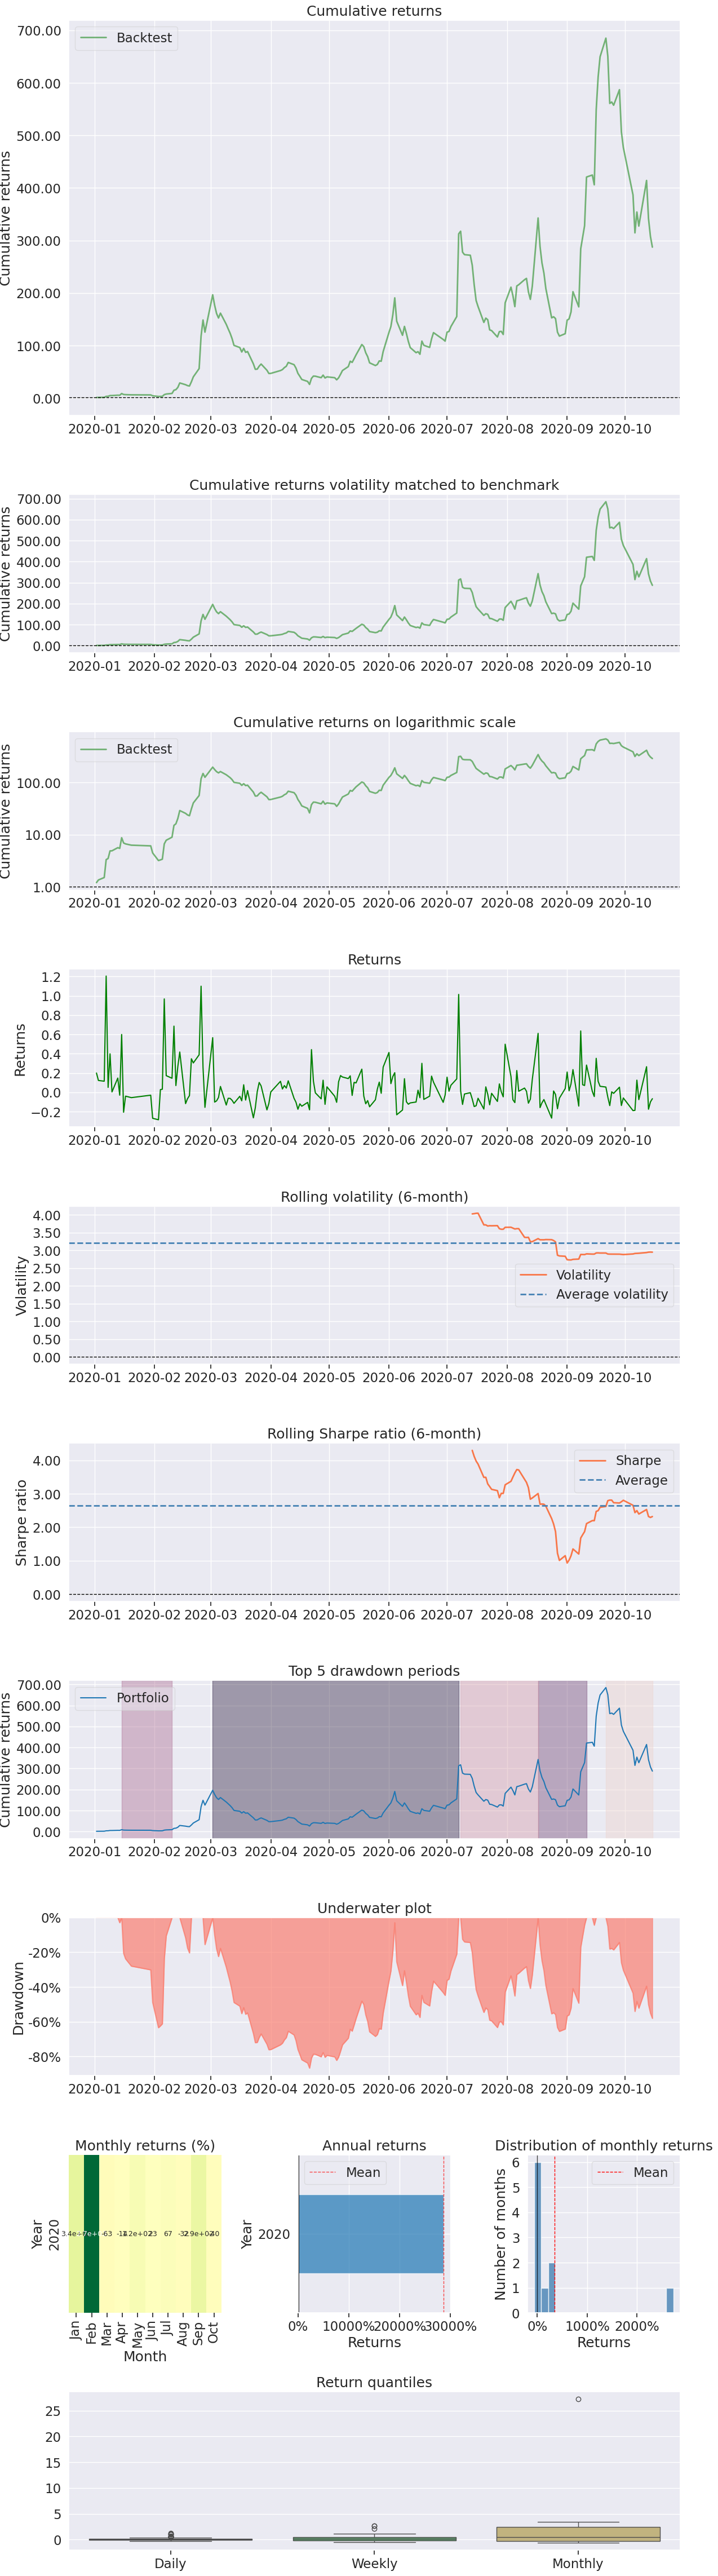

In [8]:
calculate_column = 'earn_nonsetloss_close'

earn_date_list = pd.DataFrame(columns=['Date',calculate_column])
collected_data_day['buy_date'] = pd.to_datetime(collected_data_day['buy_date'])
for i in range(len(collected_data_day)):
    earn2 = collected_data_day[calculate_column].iloc[i]
    
    Date = stock_df_raw[stock_df_raw['證券代號'] == '2330']['Date'].iloc[i]

    result_df = pd.DataFrame({
        'Date': [Date],
        calculate_column: [earn2]
    })

    # 删除全为NA的列，避免可能出现的警告
    result_df.dropna(axis=1, how='all', inplace=True)
    if not result_df.empty:
        earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True)

earn_date_list.set_index(['Date'], inplace=True)

import pyfolio as pf
earn_date_list[calculate_column] = earn_date_list[calculate_column] / 100
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')
pf.create_returns_tear_sheet( earn_date_list[calculate_column] )




In [10]:
collected_data_day

,證券代號,證券名稱,收盤價,明天收盤價,明天開盤價,X天收盤價,X天開盤價,earn_close,earn_open,earn_mix,...,earn_nonsetloss_open,buy_date,sell_date,RS20,RS60,RS240,loss_type,GMFE,MAE,BMFE
0,2028,威致,22.75,21.25,22.45,25.50,25.30,0.24,-4.00,-4.00,...,12.69,2021-01-26,2021-01-28,57.586207,93.505747,97.586207,2,22.59,-7.76,0.24
1,6224,聚鼎,107.50,118.00,114.50,132.50,138.00,0.42,-0.42,-0.42,...,20.52,2021-02-17,2021-03-09,87.263339,91.508893,90.189329,2,16.95,0.00,13.14
2,3092,鴻碩,66.80,71.30,67.80,79.50,81.40,-2.52,0.00,0.00,...,20.06,2021-02-18,2021-03-08,75.802752,90.309633,91.972477,2,14.31,-2.81,4.91
3,6129,普誠,16.50,17.60,16.50,38.80,33.50,120.45,103.03,120.45,...,103.03,2021-02-18,2021-03-18,58.600917,96.961009,98.050459,1,120.45,-0.57,0.00
4,6284,佳邦,77.10,76.50,76.90,80.40,83.60,2.75,-0.65,-0.65,...,8.71,2021-02-18,2021-02-22,68.807339,94.151376,97.534404,2,10.85,-7.84,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2363,矽統,70.60,67.50,70.00,62.40,63.10,-0.89,1.48,1.48,...,-9.86,2024-08-08,2024-09-03,98.757428,96.812534,94.759589,2,9.33,-7.56,9.33
186,3450,聯鈞,122.00,122.50,126.00,155.00,161.50,26.53,28.17,26.53,...,28.17,2024-08-09,2024-09-05,58.887088,94.705565,96.542410,1,45.71,0.00,3.67
187,3686,達能,28.60,30.00,28.50,24.75,24.20,-7.17,-6.67,-6.67,...,-15.09,2024-08-21,2024-08-29,62.978953,91.851052,95.358877,2,0.33,-23.33,0.33
188,4534,慶騰,27.80,28.60,27.75,25.75,23.55,-0.35,-6.47,-6.47,...,-15.14,2024-08-28,2024-09-02,81.135135,94.270270,98.162162,2,6.64,-18.01,6.64


Start date,2020-01-02
End date,2020-10-15
Total months,9
,Backtest
Annual return,291179.47%
Cumulative returns,40824.15%
Annual volatility,313.386%
Sharpe ratio,3.84
Calmar ratio,4032.32
Stability,0.84
Max drawdown,-72.211%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,72.21,2020-03-02,2020-04-21,2020-06-04,69
1,53.00,2020-08-17,2020-08-28,2020-09-04,15
2,48.84,2020-07-13,2020-07-27,2020-08-11,22
3,45.56,2020-06-04,2020-06-17,2020-07-07,24
4,44.51,2020-01-17,2020-02-03,2020-02-06,15


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



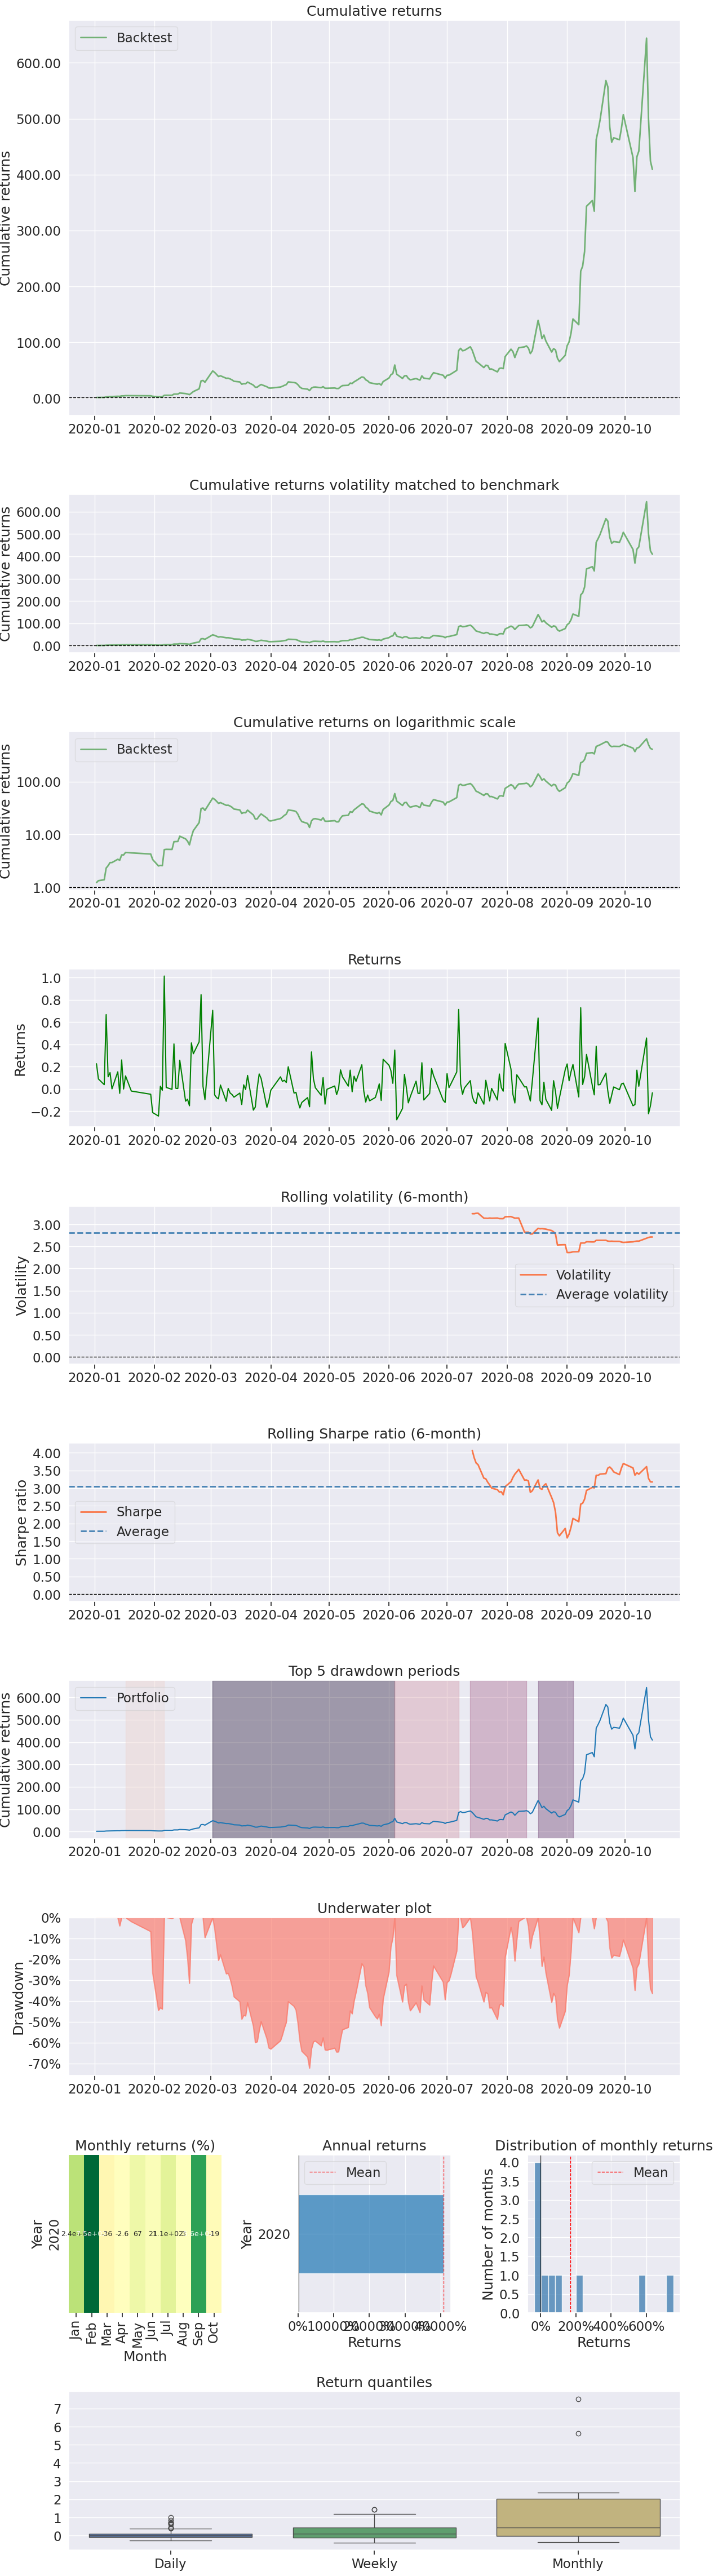

In [83]:
import pyfolio as pf

earn_date_list['earn_nonsetloss_close'] = earn_date_list['earn_nonsetloss_close'] / 100
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')

pf.create_returns_tear_sheet( earn_date_list['earn_nonsetloss_close'] )

C:\Users\USER\AppData\Local\Temp\ipykernel_20428\4271138391.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start date,2021-01-26
End date,2024-09-03
Total months,7
,Backtest
Annual return,18582.596%
Cumulative returns,2244.624%
Annual volatility,307.301%
Sharpe ratio,2.96
Calmar ratio,236.86
Stability,0.68
Max drawdown,-78.455%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,78.45,2021-07-05,2021-12-30,2023-11-14,617
1,50.42,2023-11-15,2023-12-15,2024-01-17,46
2,47.41,2024-01-17,2024-03-29,2024-04-29,74
3,44.58,2021-03-09,2021-04-16,2021-05-31,60
4,36.46,2024-08-09,2024-09-03,NaT,NaN


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



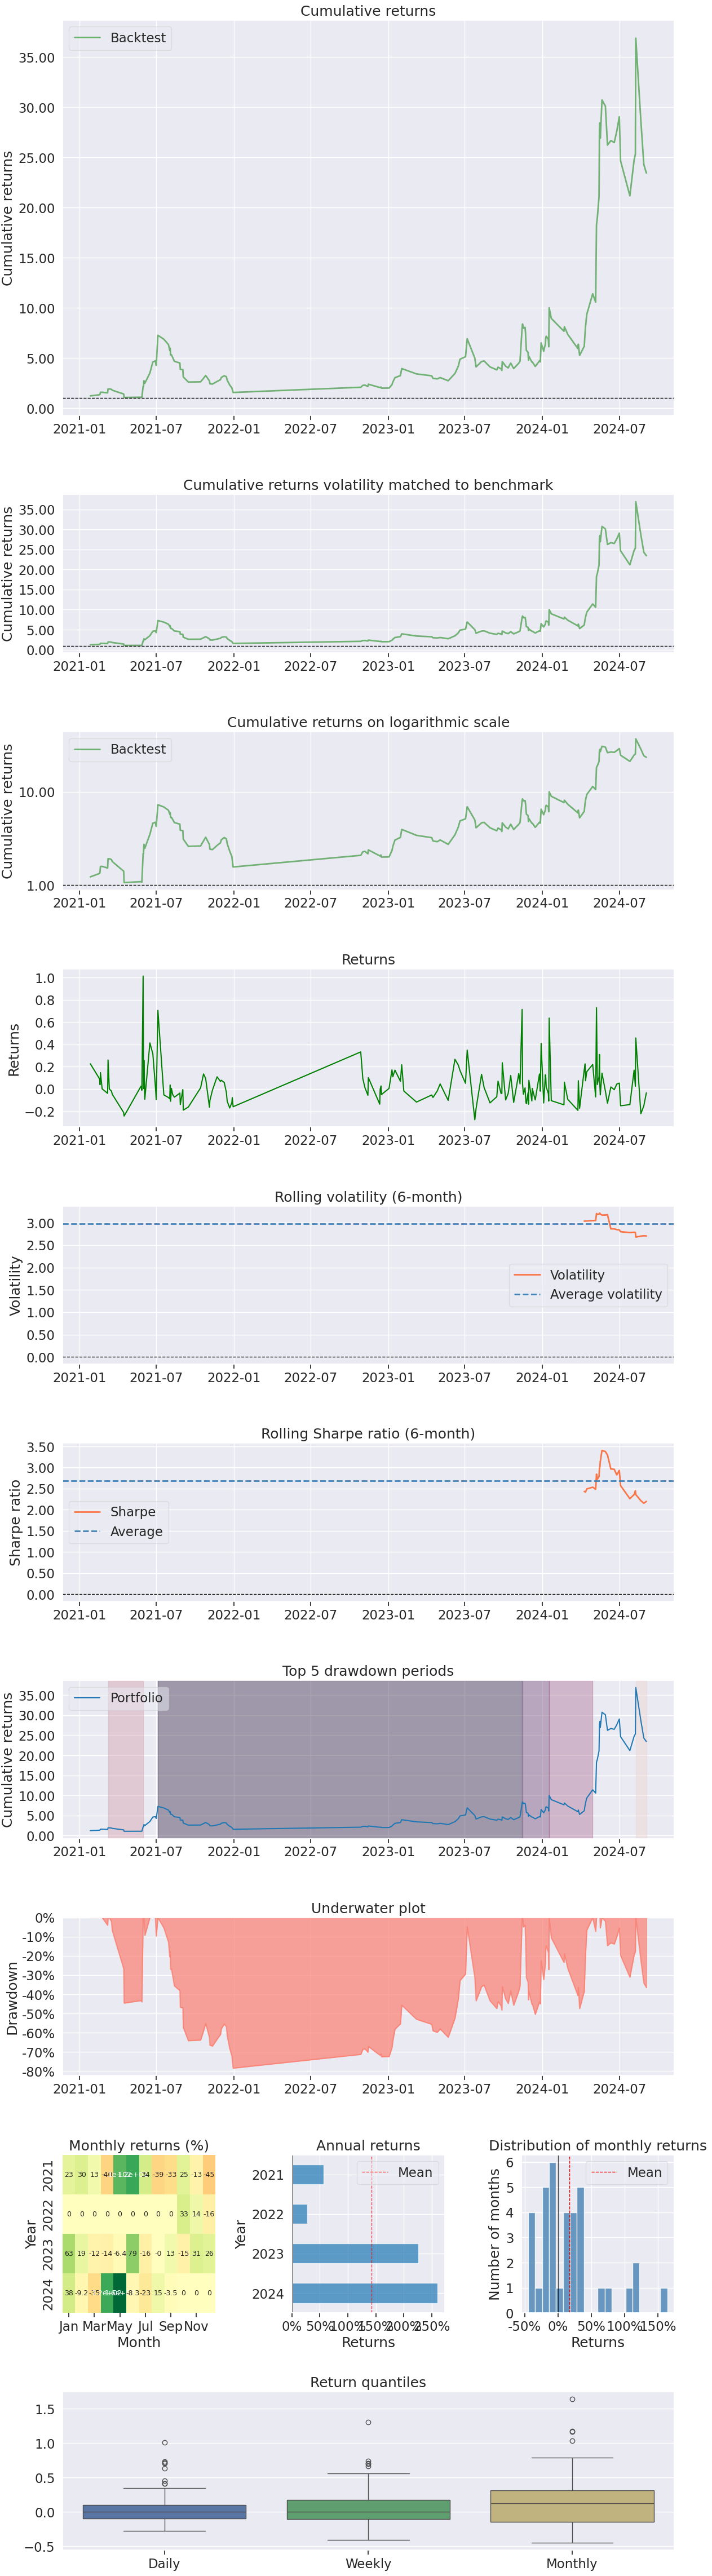

In [78]:
collected_data_day['buy_date'] = pd.to_datetime(collected_data_day['buy_date'])
stock_pf_first = collected_data_day.drop_duplicates(subset='buy_date', keep='first')
# stock_pf_first.set_index(['buy_date'], inplace=True)

# earn_type = 'earn_nonsetloss_close' 
earn_type = 'earn_nonsetloss_close'

import pyfolio as pf

stock_pf_first['buy_date'] = pd.to_datetime(stock_pf_first['buy_date'])
stock_pf_first=stock_pf_first[['buy_date', earn_type]]
stock_pf_first[earn_type] = stock_pf_first[earn_type] / 100
stock_pf_first.set_index('buy_date', inplace=True)
#处理好的收益数据
# returns = stock_pf_first['earn_mix'].tz_localize('UTC')

pf.create_returns_tear_sheet( stock_pf_first[earn_type] )

In [30]:
collected_data_day['MAE'] = abs(collected_data_day['MAE'])
import plotly.express as px

# Creating the scatter plot using plotly.express
fig = px.scatter(collected_data_day, x='MAE', y='BMFE', title='BMFE vs. MAE')

fig.add_shape(
    type='line',
    x0=min(collected_data_day['MAE']), y0=min(collected_data_day['MAE']),
    x1=max(collected_data_day['MAE']), y1=max(collected_data_day['MAE']),
    line=dict(color='red', dash='dash')  # Customize the color and style
)
# Show the plot
fig.show()

In [18]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn2 = collected_data_day[collected_data_day['earn_mix'] > 0]
negative_earn2 = collected_data_day[collected_data_day['earn_mix'] < 0]

# Create bubble chart for positive earn2 (blue)
fig = px.scatter(positive_earn2, 
                 x= positive_earn2['earn_mix'], 
                 y= abs(positive_earn2['BMFE']), 
                 size= positive_earn2['earn_mix'],
                 title="BMFE/Return",  
                 labels={'earn2': 'Return(%)', 'MAE': 'MAE(%)'},
                 size_max=20, 
                 color_discrete_sequence=["blue"])  # Blue for positive earn2

# Add bubble chart for negative earn2 (red)
fig2 = px.scatter(negative_earn2, 
                  x= negative_earn2['earn_mix'], 
                  y= abs(negative_earn2['BMFE']), 
                  size= abs(negative_earn2['earn_mix']),
                  title="BMFE/Return",  
                  size_max=20,
                  color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show()

往不利方向加減碼 下圖大概在MAE 為 5%的時候開始分開 也就是說 虧損>5%之後基本上就容易賠錢，那5%就會是一個判斷的flag

In [33]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn2 = collected_data_day[collected_data_day['earn_mix'] > 0]
negative_earn2 = collected_data_day[collected_data_day['earn_mix'] < 0]


fig = px.histogram(positive_earn2, 
                   x='MAE',  # X-axis is the 'MAE' column
                   title="MAE Count Bar Chart", 
                   labels={'MAE': 'MAE (%)', 'count': 'Count'},
                   nbins=100,
                   color_discrete_sequence=["blue"])  # Customize labels


# Create bubble chart for positive earn2 (blue)
fig2 = px.histogram(negative_earn2, 
                   x='MAE',  # X-axis is the 'MAE' column
                   title="MAE Count Bar Chart", 
                   labels={'MAE': 'MAE (%)', 'count': 'Count'},
                   nbins=100,
                   color_discrete_sequence=["red"])  # Customize labels

# # Add bubble chart for negative earn2 (red)
# fig2 = px.scatter(negative_earn2, 
#                   x= negative_earn2['earn_mix'], 
#                   y= abs(negative_earn2['BMFE']), 
#                   size= abs(negative_earn2['earn_mix']),
#                   title="BMFE/Return",  
#                   size_max=20,
#                   color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show() 

In [98]:
backday = 120
total_backday_df = pd.DataFrame(columns=['XDAY','buyday','證券代號','證券名稱', '收盤價','X天最低收盤價','差距min','差距max', 'earn_mix'])
    
for i in range(len(collected_data_day)):

    df = collected_data_day.iloc[i]
    buyday = df['buy_date']
    close_price = df['收盤價']
    stock_id = df['證券代號']
    earn_mix = df['earn_mix']

    df_his_min_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < buyday )]['收盤價'].rolling(backday).min().iloc[-1]
    df_his_max_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < buyday )]['收盤價'].rolling(backday).max().iloc[-1]

    result_df = pd.DataFrame({
    'XDAY':[backday],
    'buyday':[buyday],
    '證券代號': [stock_id],
    '證券名稱': [df['證券名稱']],
    '收盤價': [close_price],
    'X天最低收盤價': [df_his_min_price],
    '差距min': [close_price/df_his_min_price], 3
    '差距max': [df_his_max_price/ close_price], 1.25
    'earn_mix': [earn_mix]
    })

    # 删除全为NA的列，避免可能出现的警告
    result_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_backday_df = pd.concat([total_backday_df, result_df], ignore_index=True) 
total_backday_df

C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1965477156.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  '差距min': [close_price/df_his_min_price],
C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1965477156.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  '差距min': [close_price/df_his_min_price],
C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1965477156.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  '差距min': [close_price/df_his_min_price],


,XDAY,buyday,證券代號,證券名稱,收盤價,X天最低收盤價,差距min,差距max,earn_mix
0,120,2023-04-13,7402,邑錡,77.00,0.00,inf,1.077922,-3.27
1,120,2023-04-13,2739,寒舍,59.50,26.65,2.232645,1.085714,-5.50
2,120,2023-04-14,2722,夏都,53.20,29.90,1.779264,1.015038,-4.70
3,120,2023-04-26,5701,劍湖山,8.55,2.88,2.968750,0.560234,-1.97
4,120,2023-05-03,8478,東哥遊艇,521.00,217.00,2.400922,1.071017,0.51
...,...,...,...,...,...,...,...,...,...
101,120,2024-08-01,3048,益登,46.85,22.80,2.054825,1.120598,-0.67
102,120,2024-08-02,4534,慶騰,26.40,9.83,2.685656,1.149621,16.81
103,120,2024-08-07,2363,矽統,70.60,0.00,inf,1.106232,2.37
104,120,2024-08-08,3450,聯鈞,122.00,58.30,2.092624,1.213115,45.71


In [135]:
total_backday_df[total_backday_df['earn_mix'] < 0].sort_values(by='earn_mix', ascending=True).head(30)
# total_backday_df[total_backday_df['earn_mix'] > 0].sort_values(by='earn_mix', ascending=False).head(30)

a = total_backday_df[(total_backday_df['earn_mix'] < 0) & ((total_backday_df['差距max'] > 1.25) | (total_backday_df['差距min'] > 3)) ]
b = total_backday_df[(total_backday_df['earn_mix'] < 0) & ((total_backday_df['差距max'] > 1.25) ) ]
c = total_backday_df[(total_backday_df['earn_mix'] > 0) & ((total_backday_df['差距max'] > 1.25) | (total_backday_df['差距min'] > 3)) ]
d = total_backday_df[(total_backday_df['earn_mix'] > 0) & ((total_backday_df['差距max'] > 1.25) ) ]
a = a[a['X天最低收盤價'] != 0]
c  = c[c['X天最低收盤價'] != 0]
a

,XDAY,buyday,證券代號,證券名稱,收盤價,X天最低收盤價,差距min,差距max,earn_mix
56,120,2024-01-16,5210,寶碩,53.90,16.00,3.368750,1.326531,-11.82
62,120,2024-03-01,8054,安國,178.50,32.90,5.425532,1.142857,-15.13
65,120,2024-03-27,4303,信立,48.15,18.10,2.660221,1.268951,-12.13
69,120,2024-04-08,3294,英濟,45.40,18.35,2.474114,1.288546,-16.83
71,120,2024-04-11,2465,麗臺,128.50,40.40,3.180693,1.245136,-6.88
77,120,2024-05-08,1519,華城,888.00,234.50,3.786780,1.075450,-5.99
87,120,2024-05-23,4402,福大,34.45,10.40,3.312500,1.219158,-3.74
95,120,2024-06-28,2359,所羅門,166.00,36.00,4.611111,1.084337,-0.30
97,120,2024-07-02,3466,德晉,87.80,23.00,3.817391,1.144647,-3.17


In [54]:
loss_search = collected_data_day[collected_data_day['earn_mix'] < 0].sort_values(by='earn_mix').head(20)
for i in range(len(loss_search)):
    df = loss_search.iloc[i]
    buyday = df['buy_date']
    close_price = df['收盤價']
    stock_id = df['證券代號']

    df_his_min_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < buyday )]['收盤價'].rolling(120).min().iloc[-1]
    print(df['證券名稱'])
    print(close_price/df_his_min_price)



英濟
2.4741144414168934
安國
5.425531914893617
信立
2.660220994475138
寶碩
3.36875
波力-KY
2.86525974025974
業強
1.8560157790927019
康那香
1.7029411764705882
國產
1.8637236084452973
萬國通
2.2412451361867705
正淩
1.923076923076923
五福
1.7264276228419655
基亞
1.8524590163934427
中揚光
2.1222222222222222
緯穎
1.706959706959707
首利
2.2234762979683973
麗臺
3.1806930693069306
榮星
1.5545171339563861
前鼎
2.5608194622279132
訊芯-KY
2.157721796276013
華城
3.786780383795309


In [53]:
stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] < buyday )]

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank


In [30]:
twse_df_raw = pd.read_sql(query_twse, engine)
twse_df = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()
twse_df['Date'] = pd.to_datetime(twse_df['Date'])
twse_df[twse_df['Date'] > '2023-04-01'].head(30)

,Date,指數名稱,價格指數值,報酬指數值,漲跌點數,漲跌百分比,5MA,8MA,10MA,20MA,20RS,60MA,60RS,240MA,240RS
28310,2023-04-06,發行量加權股價指數,15810.77,-,57.29,-0.36,15799.900,15826.0575,15788.237,15662.8935,100.9441,15299.0770,103.3446,15011.2600,105.3261
28362,2023-04-07,發行量加權股價指數,15836.50,+,25.73,0.16,15826.904,15822.6263,15820.542,15661.8240,101.1153,15324.9332,103.3381,15006.4500,105.5313
28414,2023-04-10,發行量加權股價指數,15876.17,+,39.67,0.25,15848.186,15817.8100,15832.113,15664.7225,101.3498,15350.7288,103.4229,15000.5105,105.8375
28466,2023-04-11,發行量加權股價指數,15913.88,+,37.71,0.24,15861.076,15828.2563,15837.106,15671.8835,101.5441,15379.7418,103.4730,14994.9614,106.1282
28518,2023-04-12,發行量加權股價指數,15932.97,+,19.09,0.12,15874.058,15857.1925,15838.933,15692.2220,101.5342,15410.5410,103.3901,14990.4980,106.2871
28570,2023-04-13,發行量加權股價指數,15804.76,-,128.21,-0.80,15872.856,15861.5675,15836.378,15704.4355,100.6388,15438.3255,102.3735,14985.9393,105.4639
28622,2023-04-14,發行量加權股價指數,15929.43,+,124.67,0.79,15891.442,15871.5675,15859.173,15732.8860,101.2493,15466.7473,102.9915,14981.5060,106.3273
28674,2023-04-17,發行量加權股價指數,15963.55,+,34.12,0.21,15908.918,15883.5038,15878.552,15761.6840,101.2807,15496.1543,103.0162,14976.5672,106.5902
28726,2023-04-18,發行量加權股價指數,15869.44,-,94.11,-0.59,15900.030,15890.8375,15880.553,15794.1000,100.4770,15522.2942,102.2364,14971.3234,105.9989
28778,2023-04-19,發行量加權股價指數,15770.47,-,98.97,-0.62,15867.530,15882.5838,15870.794,15809.9755,99.7501,15545.5797,101.4467,14966.0958,105.3746


In [152]:
run_day = datetime.now().date()
month_ago = run_day - timedelta(days=10)

# 格式化日期
run_day = run_day.strftime('%Y-%m-%d')
month_ago = month_ago.strftime('%Y-%m-%d')
# 短波強勢股
stock_date_list = stock_df_raw[(stock_df_raw['Date']>=month_ago ) & (stock_df_raw['Date']<= run_day) & (stock_df_raw['證券代號'] == '2330') ]['Date']
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date'])

for day in stock_date_list:

        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) &  (stock_df_raw['20RS_rank'] > 58) & (stock_df_raw['60RS_rank'] > 90) & (stock_df_raw['240RS_rank'] > 90) & (stock_df_raw['收盤價'] > stock_df_raw['10MA'] )].copy() 
        stock_id_list = stock_df_today['證券代號'].tolist()

        for stock_id in stock_id_list:

                # 有day 跟 stock_id
                stock_his = stock_df_raw[(stock_df_raw['Date'] < day) & (stock_df_raw['證券代號'] == stock_id )]
                # 過去
                
                rs20_rank_his = stock_his['20RS_rank'].iloc[-1]

                today_close = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                stock_name = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['證券名稱'].iloc[0]
                stock_volume = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
                
                if( (rs20_rank_his < 15) & (stock_volume > 1000)):

                        result_df = pd.DataFrame({
                                '證券代號': [ stock_id],
                                '證券名稱': [stock_name],
                                '收盤價': [today_close],
                                'Date': [day]
                                })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)

collected_data


,證券代號,證券名稱,收盤價,Date
0,6535,順藥,256.50,2024-09-16
1,4716,大立,24.95,2024-09-18
2,6151,晉倫,40.80,2024-09-18
3,5905,南仁湖,22.65,2024-09-19


運算量實在是有點大

In [13]:
# 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥


stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2024-04-10' ) & (stock_df_raw['Date']<='2024-04-30' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']

collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', '明天收盤價', 'Date'])

for day in stock_date_list:

        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['成交筆數'] < 100) & (stock_df_raw['收盤價'] < 100)].copy() 

        stock_id_list = stock_df_today['證券代號'].tolist()

        for stock_id in stock_id_list:

                # 有day 跟 stock_id
                stock_his = stock_df_raw[(stock_df_raw['Date'] < day) & (stock_df_raw['證券代號'] == stock_id )]
                # 過去
                volume_mean = stock_his['成交筆數'].rolling(120).mean().iloc[-1]
                today_close = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                stock_name = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['證券名稱'].iloc[0]

                stock_af_volume = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
                stock_af_price  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                # 今天收盤很靠近季線
                if( (volume_mean < 100) & (stock_af_volume > 1000) & (stock_af_price > today_close * 1.05)):

                        result_df = pd.DataFrame({
                                '證券代號': [ stock_id],
                                '證券名稱': [stock_name],
                                '收盤價': [today_close],
                                '明天收盤價': [stock_af_price],
                                'Date': [day]
                                })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)


collected_data                               



,證券代號,證券名稱,收盤價,明天收盤價,Date


In [ ]:
# 直接屌爆大量

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2024-05-01' ) & (stock_df_raw['Date']<='2024-05-31' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']


df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2024-05-01' ) & 
                          (stock_df_raw['Date']<='2024-05-31' ) & 
                          (stock_df_raw['20RS_rank'] > 99) & 
                          (stock_df_raw['成交金額']>1000000) &
                          (stock_df_raw['成交筆數']>1000) ]
stock_id_list = df_unique0['證券代號'].unique().tolist()

moving_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','開盤價','3日後收盤價','diff'])

for stock_id in stock_id_list:
    stock_df = stock_df_raw[(stock_df_raw['Date']>='2021-09-01' ) & (stock_df_raw['證券代號'] == stock_id ) & (stock_df_raw['20RS_rank'] > 99)]

    filter_day = pd.to_datetime(stock_df['Date'].iloc[0])

    # 配合當下大盤要在 X 線之上 
    twse_close = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['價格指數值'].iloc[0]
    twse_60MA = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['60MA'].iloc[0]

    if((filter_day.strftime('%Y-%m-%d') > '2022-01-01' ) & (twse_close>twse_60MA)):
        
        # 成值不能太低
        money20 = stock_df['成交金額'].rolling(20).mean().tail(1).iloc[0]

        stock_df_af = stock_df_raw[(stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['證券代號'] == stock_id )]

        if((len(stock_df_af) >= 4) & (money20>50000000)):
            open_price = stock_df_af['開盤價'].iloc[0]
            close_price0 = stock_df_af['收盤價'].iloc[0]
            close_price1 = stock_df_af['收盤價'].iloc[1]
            close_price2 = stock_df_af['收盤價'].iloc[2]

            if (close_price0 < open_price):
                close_price3 = close_price0
            elif (close_price1 < open_price):
                close_price3 = close_price1
            # elif (close_price2 < open_price):
            #     close_price3 = close_price2
            else:
                close_price3 = stock_df_af['收盤價'].iloc[3]

            result_df = pd.DataFrame({
                'Date': [filter_day], 
                '證券代號': [stock_df['證券代號'].iloc[0]],
                '證券名稱': [stock_df['證券名稱'].iloc[0]],
                '開盤價': [open_price],
                '3日後收盤價': [close_price3],
                'diff':[ round(100 * (close_price3 / open_price - 1), 2)]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)

            if not result_df.empty:
                moving_list = pd.concat([moving_list, result_df], ignore_index=True)
                moving_list = moving_list.sort_values(by=['Date'])


In [130]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2022-01-01' ) & 
                          (stock_df_raw['Date']<='2024-12-31' ) & 
                          (stock_df_raw['20RS_rank'] > 99) & 
                          (stock_df_raw['成交金額']>1000000) &
                          (stock_df_raw['成交筆數']>1000) ]
stock_id_list = df_unique0['證券代號'].unique().tolist()

moving_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','開盤價','3日後收盤價','diff'])

for stock_id in stock_id_list:
    stock_df = stock_df_raw[(stock_df_raw['Date']>='2021-09-01' ) & (stock_df_raw['證券代號'] == stock_id ) & (stock_df_raw['20RS_rank'] > 99)]

    filter_day = pd.to_datetime(stock_df['Date'].iloc[0])

    # 配合當下大盤要在 X 線之上 
    twse_close = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['價格指數值'].iloc[0]
    twse_60MA = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['60MA'].iloc[0]

    if((filter_day.strftime('%Y-%m-%d') > '2022-01-01' ) & (twse_close>twse_60MA)):
        
        # 成值不能太低
        money20 = stock_df['成交金額'].rolling(20).mean().tail(1).iloc[0]

        stock_df_af = stock_df_raw[(stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['證券代號'] == stock_id )]

        if((len(stock_df_af) >= 4) & (money20>50000000)):
            open_price = stock_df_af['開盤價'].iloc[0]
            close_price0 = stock_df_af['收盤價'].iloc[0]
            close_price1 = stock_df_af['收盤價'].iloc[1]
            close_price2 = stock_df_af['收盤價'].iloc[2]

            if (close_price0 < open_price):
                close_price3 = close_price0
            elif (close_price1 < open_price):
                close_price3 = close_price1
            # elif (close_price2 < open_price):
            #     close_price3 = close_price2
            else:
                close_price3 = stock_df_af['收盤價'].iloc[3]

            result_df = pd.DataFrame({
                'Date': [filter_day], 
                '證券代號': [stock_df['證券代號'].iloc[0]],
                '證券名稱': [stock_df['證券名稱'].iloc[0]],
                '開盤價': [open_price],
                '3日後收盤價': [close_price3],
                'diff':[ round(100 * (close_price3 / open_price - 1), 2)]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)

            if not result_df.empty:
                moving_list = pd.concat([moving_list, result_df], ignore_index=True)
                moving_list = moving_list.sort_values(by=['Date'])


C:\Users\USER\AppData\Local\Temp\ipykernel_16856\3242393230.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_list = pd.concat([moving_list, result_df], ignore_index=True)
